<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/IASAC-UMH.png width="450" height="200"></small>

# <font color="steelblue">Modelos lineales de regresión para respuesta cuantitativa III</font>


**Autoría**: 

*   Fernando Borrás (f.borras@umh.es)
*   Federico Botella (federico@umh.es)
*   Inés Hernández (ines.hernandezp@umh.es)
*   Mª Asunción Martínez Mayoral (asun.mayoral@umh.es)
*   Josep Moltó (j.molto@umh.es)
*   Javier Morales (j.morales@umh.es) 

Departamento de Estadística, Matemáticas e Informática. 

Universidad Miguel Hernández de Elche. 


**Financiación**: El material que aparece a continuación se ha desarrollado dentro del marco del proyecto UNIDIGITAL- IASAC.

**Fecha última edición**: 01/03/2023

**Licencia**: <small><a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /></small>

No olvides hacer una copia si deseas utilizarlo. Al usar estos contenidos, acepta nuestros términos de uso y nuestra política de privacidad. 


# <font color="steelblue">Configuración del cuaderno</font>

Para garantizar la funcionalidad completa de este cuaderno, es preciso ejecutar la celda de código a continuación.

In [ ]:
#@title <b><font color="steelblue" size="+1"> Configuración del cuaderno
from io import StringIO 
import sys
import numpy as np      # importamos numpy como np
import pandas as pd     # importamos pandas como pd
from plotnine import *  # importamos módulo para gráficos
import math             # importamos módulo para cáculos matemáticos
import random           # importamos módulo para generadores de números aleatorios


# Esta línea configura matplotlib para mostrar las figuras incrustadas en el jupyter notebook
# Configuraciónde entorno gráfico
%matplotlib inline
import matplotlib.pyplot as plt # importamos matplotlib como plt
import seaborn as sns # importamos seaborn como sns
sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
    print('Comenzamos....')

with Capturing(output) as output:
    # Librerías
    import os
    !pip install jupyterquiz
    from jupyterquiz import display_quiz
    import json
    import base64
    # Lectura ficheros json
    # A configurar pra cada cuaderno en función de las preguntas de autoevalaución
    for i in range(1,7):
      !wget {f"https://raw.githubusercontent.com/ia4legos/MachineLearning/main/autoeval/auto_40_{i}.json"}
    print("Cuaderno configurado")

if output[-1]=='Cuaderno configurado':
    print(output[-1])
else: 
    print(output[:-2])

Cuaderno configurado


# <font color="steelblue">Introducción</font>

**Descripción:** Introducción a los modelos lineales con coeficientes penalizados para tratar diferentes problemas que aparecen en los modelos de regresión lineal habituales. En concreto se presentan los modelos de regresión de cresta (rigde regression), regresión de lazo (lasso regression), y de red elástica (elastic net). 

**Nivel de Formación:** B

**Recomendaciones antes de usarlo:** Haber cursado el cuaderno referido a modelos lineales de regresión y conocimientos básicos de modelización estadística.

## <font color="steelblue">Objetivos de aprendizaje</font>

*   Desarrollar modelos lineales basados en coeficientes penalizados.
*   Conocer las características de los modelos lineales de penalización más habituales.
* Aplicar los modelos con coeficientes penalizados en diferentes situaciones prácticas.
* Determinar cuando resultan de utilidad los modelos de coeficientes penalizados frente a los modelos de regresión lineal habituales.
* Establecer estrategias de validación cruzada para estimar los parámetros involucrados en los modelos con coeficientes penalizados.



## <font color="steelblue">Contenidos</font>

* Bancos de datos
* Métodos de regularización
  * Regresión de cresta (rigde regression)
  * Regresión de lazo (lasso regression)
  * Regresión de red elástica (elastic net)
  * Resumen comparativo de modelos
* Ampliar conocimientos

# <font color="steelblue">Bancos de datos</font>

A continuación se cargan los los bancos de datos que se van a utilizar en este cuaderno. Si quieres una descripción de estos bancos de datos pincha [aquí](https://colab.research.google.com/drive/1zD2LSsTpweW8fx2PNUbXT3_z3RqQMm_y?authuser=4#scrollTo=kqppEi5U-K8N). Estos son:

* Housing
* US economic time series 
* Meat spec


En ambos modelos en primer lugar ajustamos el modelo de regresión lineal múltiple habitual para poder comparar los resultados con los métodos de regularización. En este caso el primer banco de datos corresponde con uno de los analizados en cuadernos anteriores, pero a diferencia del anterior cuaderno se carga una versión de este que ya ha sido preprocesada para evitar sobrecargar el cuaderno con demasiado código. Los otros bancos de datos es la primera vez que los utilizamos y por lo tanto tenemos que realizar el preprocesado. En primer lugar cargamos las funciones y módulos que utilizaremos a lo largo del cuaderno.


In [ ]:
# Ajuste del modelo
from sklearn.linear_model import LinearRegression
# Preprocesado y preapración de muestras
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Medidas de bondad de ajuste
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Housing Dataset

`Housing` recoge información recopilada por el Servicio del Censo de los EE. UU. sobre viviendas en el área de Boston MA con el objetivo de predecir el valor medio de las viviendas ocupadas por sus propietarios en miles de dólares (`MEDV`)

En este caso cargamos los datos preprocesados, de forma que solo es necesario asignar respuesta y predictoras. Hacemos un pequeño análisis de correlación y dividimos las muestras en entrenamiento y validación.

In [ ]:
# Housing Dataset 
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/housing_clean.csv'
housing_clean = pd.read_csv(url)
# Asignamos
y2 = housing_clean['MEDV']
X2 = housing_clean.drop(columns=['MEDV'])

Observamos a continuación el gráfico de correlaciones para las variables de nuestro conjunto de datos.

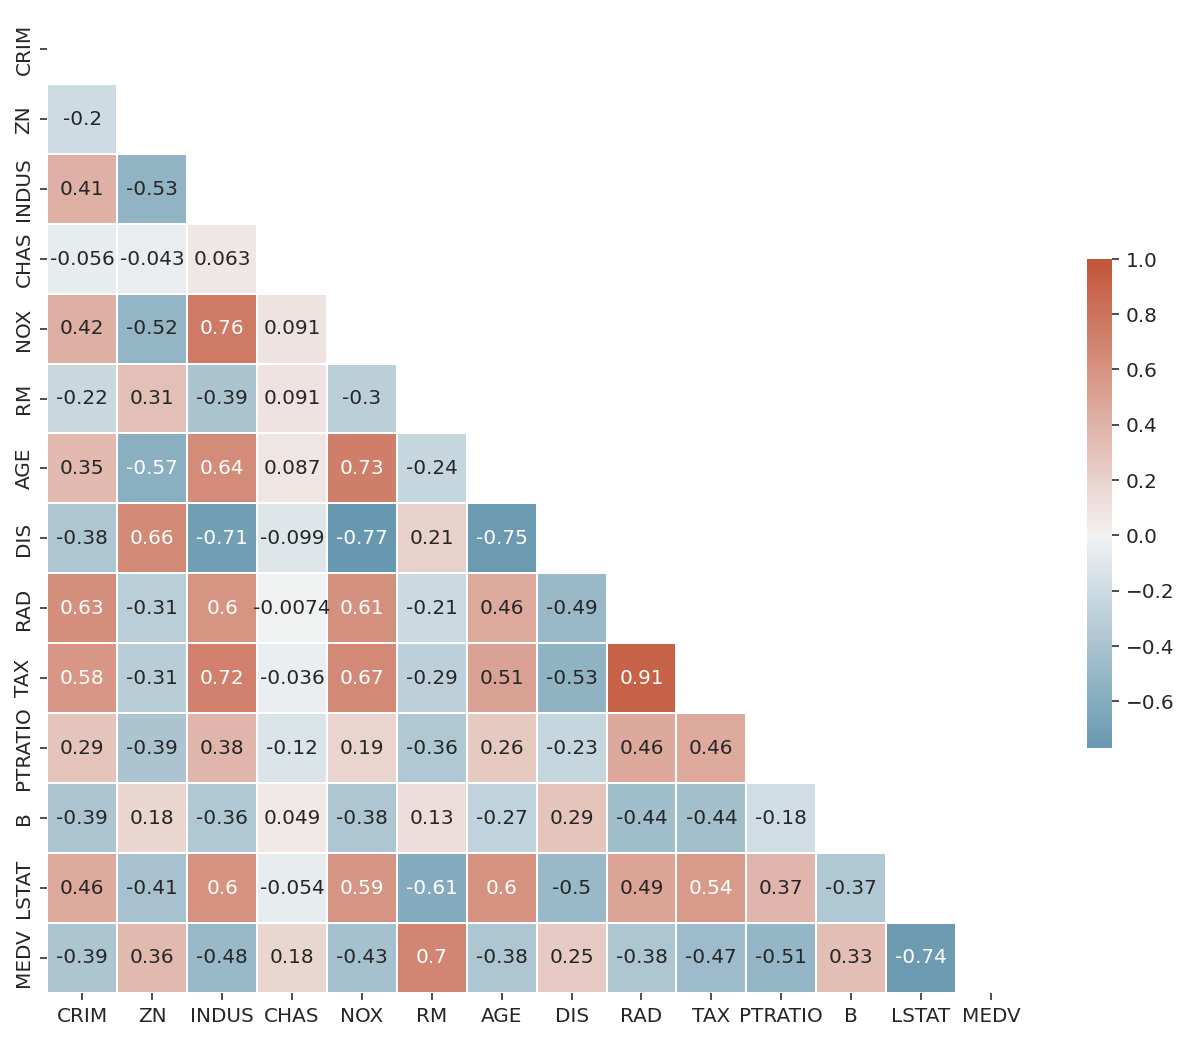

In [ ]:
# Obtenemos la matriz de correlaciones
corr = housing_clean.corr()
# Generamos un artificio para hacer ceros por encima de la diagonal
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configuración del gráfico
f, ax = plt.subplots(figsize=(11, 9))
# Paleta de colores
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# gráfico de intensidad
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Las variables predictoras que observamos que tienen una mayor correlación positiva son `RAD` y `TAX` y negativa son `DIS` y `NOX`. Dividimos las muestras en entrenamiento (80%) y validación (20%).

In [ ]:
# División de muestras normalizadas
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)

A continuación ajustamos el modelo lineal múltiple al conjunto de datos y obtenemos su precisión y su bondad del ajuste.

Vemos la estimación de los parámetros del modelo:

In [ ]:
# Planteamos el modelo
lr1 = LinearRegression()
# Entrenamos el modelo
lr1.fit(X2_train, y2_train)
# Obtenemos la interceptación del modelo
np.round(lr1.intercept_,3)

3.292

Veamos ahora los coeficientes del modelo asociados con cada una de las posibles predictoras.

In [ ]:
# Coeficientes del modelo
pd.DataFrame(np.round(lr1.coef_,3), index = X2_train.columns, columns =["coeficientes"]).T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coeficientes,-0.106,0.076,0.03,0.077,-0.217,0.339,-0.019,-0.331,0.248,-0.195,-0.215,0.123,-0.395


El modelo resultante tiene la siguiente ecuación:

$$\widehat{MEDV} = 3.292 -0.106CRIM+0.076ZN+0.03INDUS+0.077CHAS-0.217NOX+0.339RM-0.019AGE-0.331DIS+0.248RAD-0.195TAX-0.215PTRATIO+0.123B-0.395LSTAT$$

Observamos gráficamente los coeficientes del modelo.

<ipython-input-9-ff4a1b20aaad>:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


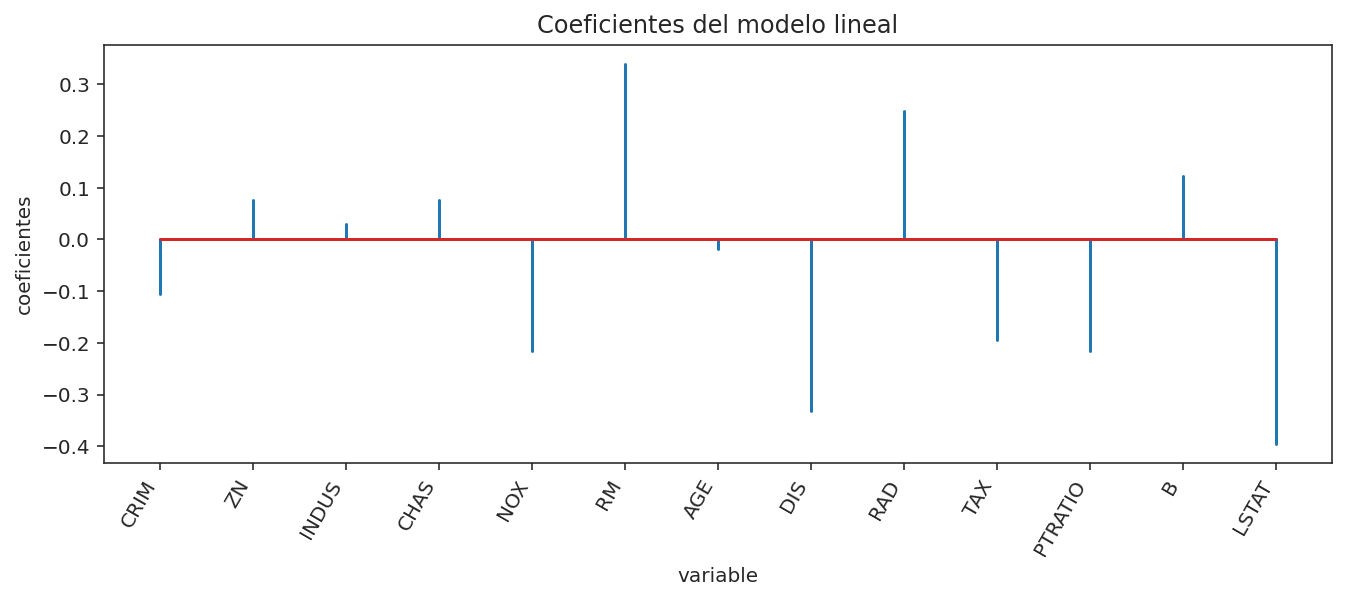

In [ ]:
# Dataframe con el valor de los coeficientes para cada variable
df_coeficientes_lr1 = pd.DataFrame(
                        {'predictor': X2_train.columns,
                         'coef': lr1.coef_}
                  );
# Gráfico
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes_lr1.predictor, df_coeficientes_lr1.coef, markerfmt=' ');
plt.xticks(rotation=60, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lineal');

Obtenemos las medidas de calidad del ajuste tanto para la muestra de entrenamiento como la de validación.

In [ ]:
# Valores de predicción modelo
y2_train_pred = lr1.predict(X2_train)
y2_test_pred = lr1.predict(X2_test)
# valores de R2
print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y2_train, y2_train_pred),
        r2_score(y2_test, y2_test_pred)))
# valores de MSE
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y2_train, y2_train_pred),
        mean_squared_error(y2_test, y2_test_pred)))
# valores de RMSE
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y2_train, y2_train_pred)),
        np.sqrt(mean_squared_error(y2_test, y2_test_pred))))

R^2 entrenamiento: 0.751, validación: 0.669
MSE entrenamiento: 0.256, validación: 0.288
RMSE entrenamiento: 0.506, validación: 0.536


La capacidad explicativa del modelo es del 75% para la muestra de entrenamiento y el 67% para la de validación. 

### US economic time series Dataset

En este banco de datos se recoge la información de la serie temporal de desempleados en EEUU. Se está interesado en predecir el desempleo (`unemploy`) dentro la economía de EEUU.



Cargamos el fichero de datos, que está sin preprocesar.

In [ ]:
# US economic time series Dataset 
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/US_economic_time_series.csv'
economic = pd.read_csv(url, index_col=False, usecols=[2, 3, 4, 5, 6, 7])
economic.head()

,date,pce,pop,psavert,uempmed,unemploy
0,1967-07-01,506.7,198712.0,12.6,4.5,2944
1,1967-08-01,509.8,198911.0,12.6,4.7,2945
2,1967-09-01,515.6,199113.0,11.9,4.6,2958
3,1967-10-01,512.2,199311.0,12.9,4.9,3143
4,1967-11-01,517.4,199498.0,12.8,4.7,3066


Observamos el tipo de cada una de las variables y si hay valores faltantes.

In [ ]:
economic.dtypes

date         object
pce         float64
pop         float64
psavert     float64
uempmed     float64
unemploy      int64
dtype: object

In [ ]:
economic.isnull().sum()

date        0
pce         0
pop         0
psavert     0
uempmed     0
unemploy    0
dtype: int64

Dado que no hay valores ausentes podemos realizar la estandarización, asignar el vector de respuestas y la matriz de predictoras para su posterior división, de cara a la fase de análisis exploratorio y entrenamiento del modelo. Por el momento dejamos fuera del análisis la variable temporal `date`.

In [ ]:
# Descartamos la variable date
economic = economic.drop(columns=['date'])
# Estandarización del conjunto de predictoras
scaler = preprocessing.StandardScaler(with_mean=False).fit(economic)
X_scaled = scaler.transform(economic)
# Dataframe estandarizado de datos
nombres = ['pce', 'pop', 'psavert', 'uempmed', 'unemploy']
economic_norm = pd.DataFrame(X_scaled, columns = nombres)
economic_norm.head()

,pce,pop,psavert,uempmed,unemploy
0,0.142584,5.421819,4.254462,1.096741,1.115296
1,0.143456,5.427249,4.254462,1.145485,1.115675
2,0.145088,5.432760,4.018103,1.121113,1.120600
3,0.144131,5.438162,4.355759,1.194229,1.190685
4,0.145595,5.443265,4.321993,1.145485,1.161515


Igual que para el conjunto de datos `Housing`, calculamos el gráfico de correlaciones.

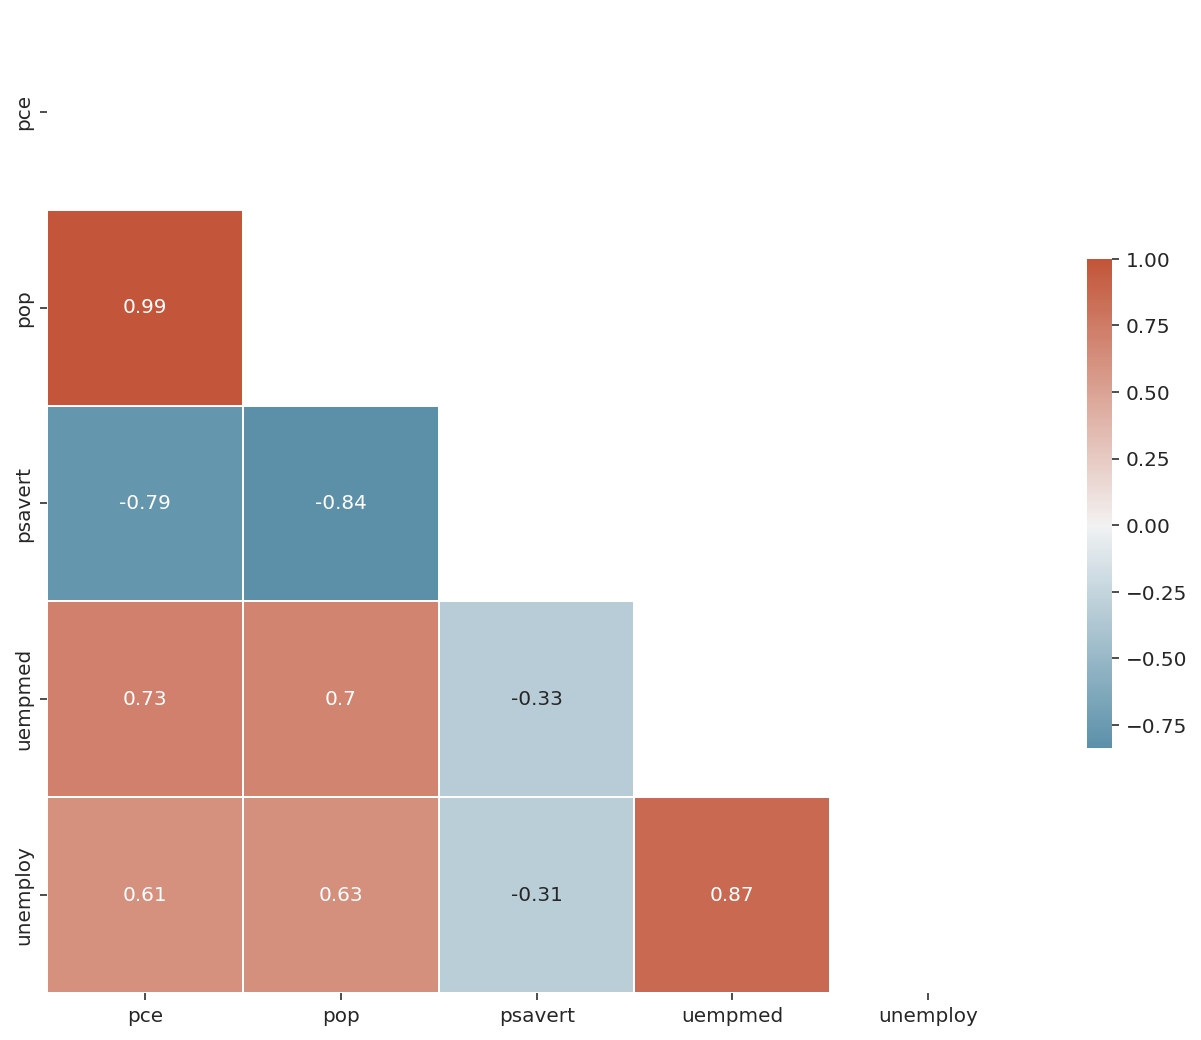

In [ ]:
# Obtenemos la matriz de correlaciones
corr = economic_norm.corr()
# Generamos un artificio para hacer ceros por encima de la diagonal
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configuración del gráfico
f, ax = plt.subplots(figsize=(11, 9))
# Paleta de colores
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# gráfico de intensidad
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Las variables predictoras que tienen una mayor correlación positiva son `pop` y `pce` y negativa `psavert` y `pop`. Construimos la estructura de respuesta y predictoras, y dividimos en muestra de entrenamiento (80%) y validación (20%).

In [ ]:
# Asignamos
y3 = economic_norm['unemploy']
X3 = economic_norm.drop(columns=['unemploy'])
# División de muestras 
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20, random_state=42)

Una vez dividido el conjunto de datos, como en el ejemplo anterior, ajustamos un modelo de regresión lineal múltiple y obtenemos los valores de $R^2$, MSE y RMSE.

In [ ]:
# Planteamos el modelo
lr2 = LinearRegression()
# Entrenamos el modelo
lr2.fit(X3_train, y3_train)
# Obtenemos los pesos o coeficientes del modelo
np.round(lr2.intercept_,3)

-13.149

In [ ]:
# Coeficientes del modelo
pd.DataFrame(np.round(lr2.coef_,3), index = X3_train.columns, columns =["coeficientes"]).T

,pce,pop,psavert,uempmed
coeficientes,-2.101,2.337,0.265,0.855


El modelo resultante es:

$$\widehat{unemploy} = -13.149 - 2.101pce+2.337pop + 0.265psavert +0.855uempmed$$

Tan solo `pce` tiene efecto sobre la disminución del desempleo, mientras que las otras tres variables contribuyen directamente al aumento de desempleados.

<ipython-input-19-8a6d516bfbf1>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


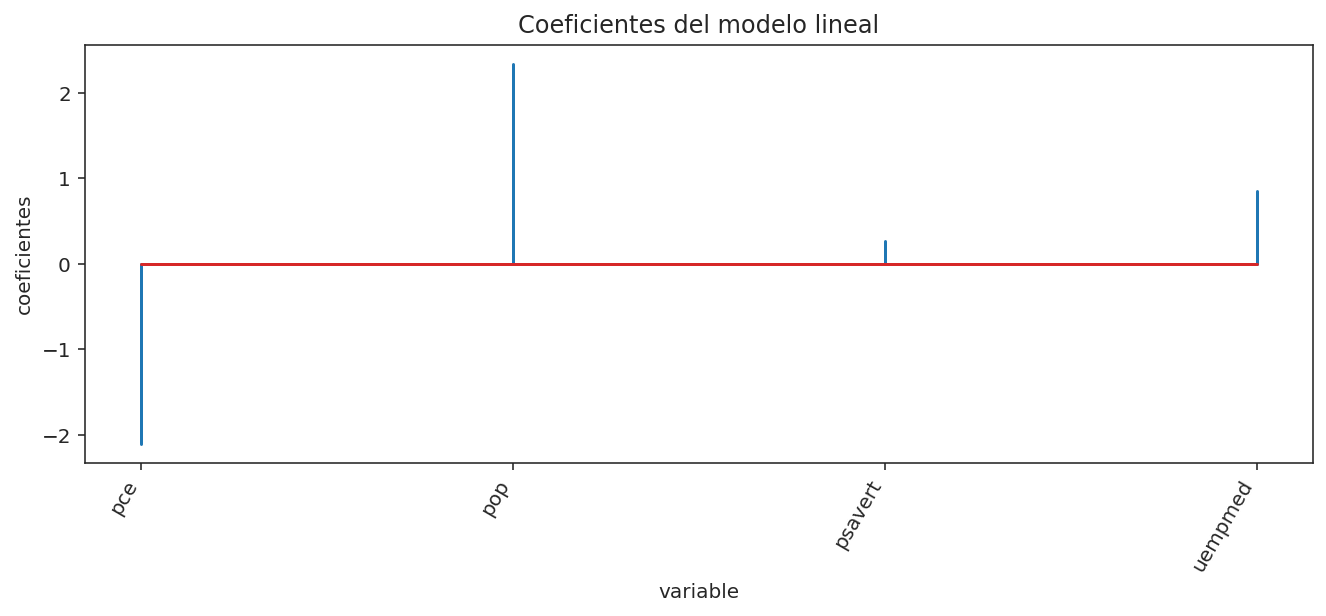

In [ ]:
# Dataframe con el valor de los coeficientes para cada variable
df_coeficientes_lr2 = pd.DataFrame(
                        {'predictor': X3_train.columns,
                         'coef': lr2.coef_}
                  );

# Gráfico
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes_lr2.predictor, df_coeficientes_lr2.coef, markerfmt=' ');
plt.xticks(rotation=60, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lineal');

In [ ]:
# Valores de predicción modelo
y3_train_pred = lr2.predict(X3_train)
y3_test_pred = lr2.predict(X3_test)
# valores de R2
print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y3_train, y3_train_pred),
        r2_score(y3_test, y3_test_pred)))
# valores de MSE
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y3_train, y3_train_pred),
        mean_squared_error(y3_test, y3_test_pred)))
# valores de RMSE
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y3_train, y3_train_pred)),
        np.sqrt(mean_squared_error(y3_test, y3_test_pred))))

R^2 entrenamiento: 0.843, validación: 0.889
MSE entrenamiento: 0.147, validación: 0.139
RMSE entrenamiento: 0.383, validación: 0.373


Se realiza un buen ajuste del modelo ya que explica el 88.9% de la variabilidad de la respuesta para el conjunto de validación.

### Meat spec Dataset

Cada una de las variables predictoras hace referencia al valor de la muestra para una longitud de onda específica. Con la base de datos `meatspec` el objetivo que se persigue es predecir el contenido en grasa (`fat`).Cargamos los datos y realizamos el preprocesamiento correspondiente.

In [ ]:
# meat spec Dataset 
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/meatspec.csv'
meatspec = pd.read_csv(url, index_col=0)
meatspec.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
1,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
2,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
3,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
4,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
5,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


Tenemos 100 longitudes de onda diferentes para cada una de las muestras.

In [ ]:
meatspec.dtypes

V1      float64
V2      float64
V3      float64
V4      float64
V5      float64
         ...   
V97     float64
V98     float64
V99     float64
V100    float64
fat     float64
Length: 101, dtype: object

Todas las variables contenidas en la base de datos son numéricas de tipo float64. Procedemos a estudiar la existencia de valores ausentes.

In [ ]:
meatspec.isnull().sum().sum()

0

No se observan valores ausentes, por lo que realizamos la estandarización, asignación del vector de respuestas y la matriz de predictoras para su posterior división, de cara a la fase de análisis exploratorio y entrenamiento del modelo.

In [ ]:
# Estandarización del conjunto de predictoras
scaler = preprocessing.StandardScaler(with_mean=False).fit(meatspec)
X_scaled_meatspec = scaler.transform(meatspec)
# Dataframe estandarizado de datos
nombres = meatspec.columns
meatspec_norm = pd.DataFrame(X_scaled_meatspec, columns = nombres)
meatspec_norm.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,6.387323,6.348703,6.310809,6.273476,6.236750,6.200676,6.165414,6.131196,6.097745,6.064911,...,5.514104,5.477597,5.442079,5.408253,5.376668,5.347781,5.321853,5.298799,5.278335,1.770171
1,6.916265,6.883562,6.851228,6.819428,6.788029,6.757071,6.726821,6.697540,6.668748,6.640625,...,6.088198,6.066832,6.046272,6.026748,6.008574,5.992103,5.977332,5.964275,5.952768,3.154839
2,6.302118,6.267324,6.232966,6.199127,6.165689,6.132558,6.099923,6.067929,6.036468,6.005098,...,4.974169,4.939905,4.907132,4.876352,4.848116,4.823225,4.802136,4.784931,4.770872,0.660864
3,6.887766,6.849346,6.811391,6.774134,6.737155,6.700405,6.664081,6.628359,6.593232,6.558350,...,5.499715,5.456857,5.415481,5.376264,5.339991,5.307482,5.279272,5.255448,5.235310,0.464178
4,6.803025,6.765178,6.727933,6.691162,6.654714,6.618871,6.583941,6.550017,6.516834,6.484317,...,6.103715,6.066573,6.031020,5.997389,5.966298,5.938377,5.913852,5.892800,5.874338,2.006194


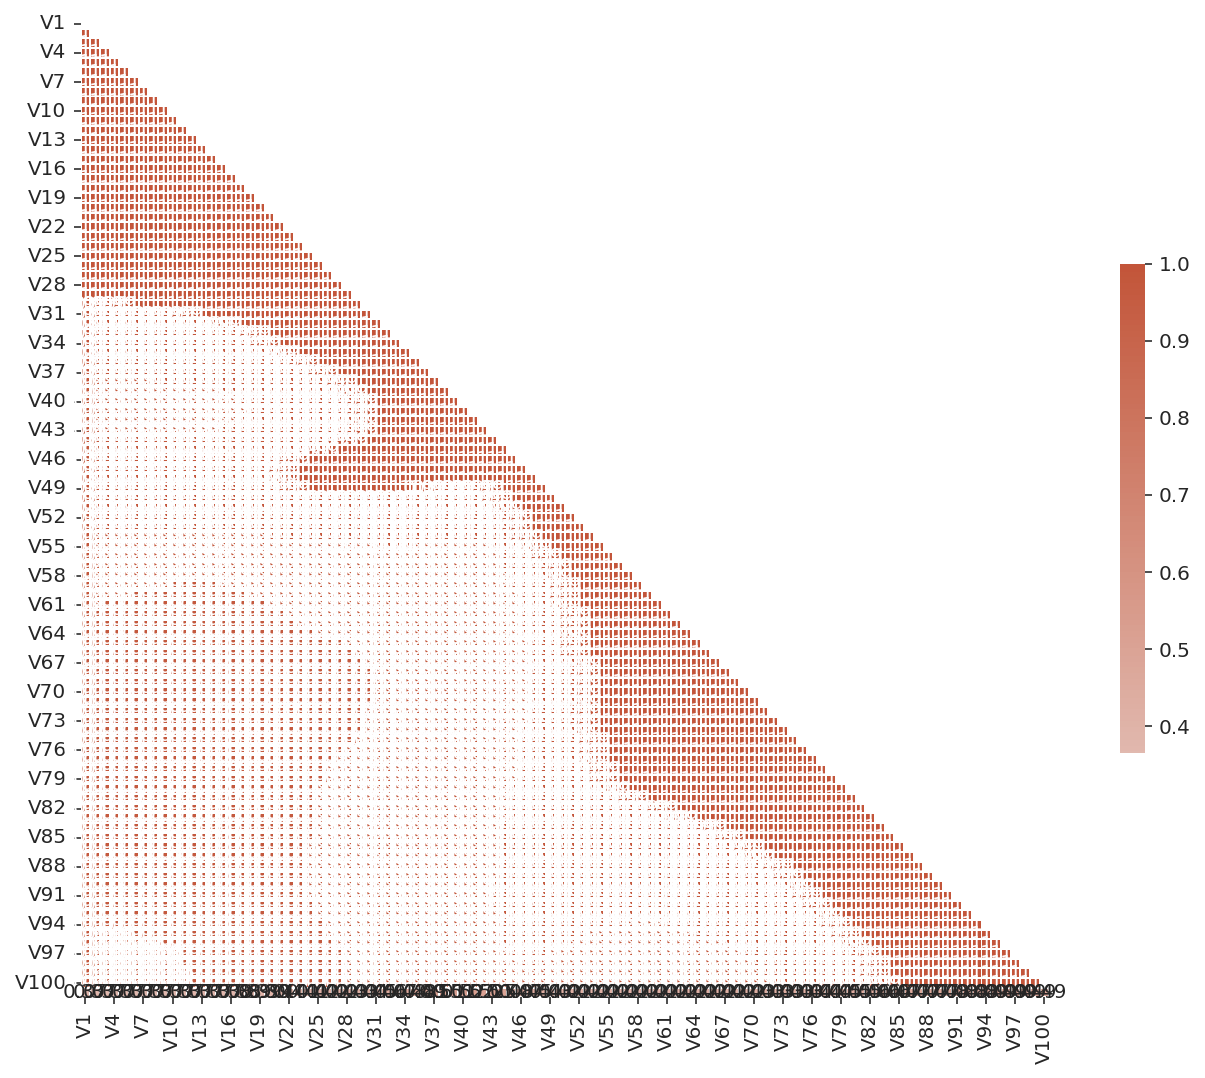

In [ ]:
# Obtenemos la matriz de correlaciones
corr = meatspec_norm.corr()
# Generamos un artificio para hacer ceros por encima de la diagonal
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configuración del gráfico
f, ax = plt.subplots(figsize=(11, 9))
# Paleta de colores
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# gráfico de intensidad
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

En la matriz de correlaciones obtenida se plasma que hay variables que están altamente correlacionadas positivamente, lo que supone un problema a la hora de implementar modelos de regresión lineal. Podemos tener graves problemas de multicolinealidad.

Una vez obtenidos los datos estandarizados, construimos la estructura de respuesta y predictoras y dividimos en muestra de entrenamiento (80%) y validación (20%).

In [ ]:
# Asignamos
y4 = meatspec_norm['fat']
X4 = meatspec_norm.drop(columns=['fat'])
# División de muestras 
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.20, random_state=42)

Por último ajustamos un modelo de regresión lineal múltiple y obtenemos los valores de $R^2$, MSE y RMSE.

In [ ]:
# Planteamos el modelo
lr3 = LinearRegression()
# Entrenamos el modelo
lr3.fit(X4_train, y4_train)
# Obtenemos los pesos o coeficientes del modelo
np.round(lr3.intercept_,3)

0.776

In [ ]:
# Coeficientes del modelo
pd.DataFrame(np.round(lr3.coef_,3), index = X4_train.columns, columns =["coeficientes"]).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
coeficientes,438.357,-540.77,-300.162,940.6,-1062.617,770.545,-683.267,285.874,454.551,-504.369,...,346.873,317.974,-452.318,45.22,566.145,-778.004,-108.041,473.505,-362.681,228.937


El modelo resultante resulta díficil de escribir debido al alto número de predictoras:

$$\widehat{fat} = 0.776 + 438.357V1 - 540.77V2 + ...+ 228.937V100$$

Vemos la solución gráfica para entender mejor el comportamiento de los coeficientes:

<ipython-input-29-2353d0153e31>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


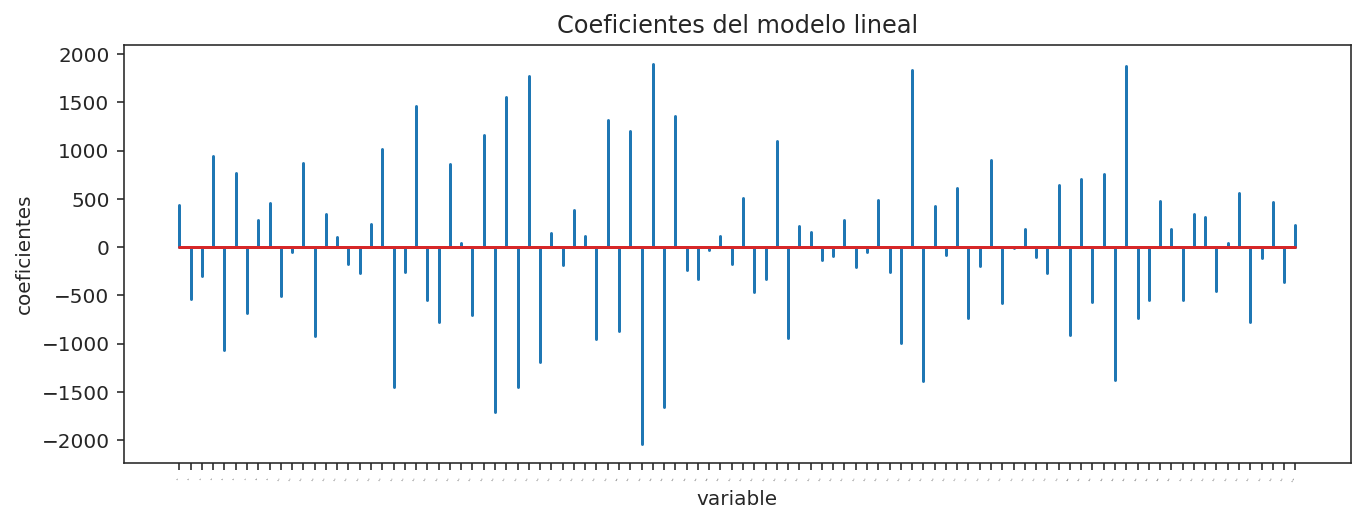

In [ ]:
# Dataframe con el valor de los coeficientes para cada variable
df_coeficientes_lr3 = pd.DataFrame(
                        {'predictor': X4_train.columns,
                         'coef': lr3.coef_}
                  );

# Gráfico
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes_lr3.predictor, df_coeficientes_lr3.coef, markerfmt=' ');
plt.xticks(rotation=60, ha='right', size=0)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lineal');

Analizamos la calidad del ajuste:

In [ ]:
# Valores de predicción modelo
y4_train_pred = lr3.predict(X4_train)
y4_test_pred = lr3.predict(X4_test)
# valores de R2
print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y4_train, y4_train_pred),
        r2_score(y4_test, y4_test_pred)))
# valores de MSE
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y4_train, y4_train_pred),
        mean_squared_error(y4_test, y4_test_pred)))
# valores de RMSE
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y4_train, y4_train_pred)),
        np.sqrt(mean_squared_error(y4_test, y4_test_pred))))

R^2 entrenamiento: 0.996, validación: 0.762
MSE entrenamiento: 0.003, validación: 0.256
RMSE entrenamiento: 0.059, validación: 0.506


Parece que el modelo sobreajusta los datos ya que el modelo de entrenamiento se ajusta de manera casi perfecta pero una vez se prueba con el conjunto de validación se observa una disminución considerable en los valores de $R^2$ y un aumento del MSE y RMSE. Esto se puede deber al gran número de predictoras consideradas. Dado que están muy correlacionadas entre si tenemos problemas para identificar las variables relevantes en el modelo.

Por ese motivo se introducen los métodos de regularización para tratar de solucionar este tipo de problemas.

# <font color="steelblue">Métodos de regularización</font>


Se presentan diferentes modificaciones de los modelos lineales vistos hasta ahora para solucionar problemas como el sobreajuste. Para ello se plantean diferentes métodos de regularización que son modificaciones del algoritmo de estimación de los parámetros del modelo introduciendo cierto tipo de restricciones o penalizaciones para evitar los problemas de sobreajuste o la tendencia a obtener modelos muy complejos. Se trata pues de establecer cierto equilibrio entre la capacidad explicativa y la complejidad del modelo. Estas modificaciones eliminan parte de los problemas que aparecen cuando utilizamos el criterio de los mínimos cuadrados habitual.

El objetivo que se persigue con este tipo de métodos es estudiar como varía el valor de los coeficientes del modelo manteniendo su capacidad explicativa. Es decir, buscamos un modelo cuyos coeficientes reflejen de la mejor manera posible la importancia de las variables y muestre las variables que realmente son relevantes a la hora de explicar la respuesta.

## <font color="steelblue">Regresión de Cresta (Ridge Regression)</font>

El primer método de regularización que se presenta es la **Regresión de Cresta** (Ridge Regression) que aborda algunos de los problemas de los mínimos cuadrados ordinarios imponiendo una penalización sobre los coeficientes en el proceso de estimación. El problema principal que se trata de resolver con este método de regularización es el de colinealidad entre las predictoras. Este problema es muy común y aparece cuando las predictoras están muy correlacionas entre si, lo que es muy habitual cuando disponemos de bancos de datos con muchas variables. Para un modelo lineal de la forma:

$$\mathbf{y} = \mathbf{X}\mathbf{w} +\mathbf{\epsilon}$$

los coeficientes de la cresta minimizan una suma de cuadrados residual penalizada:

$$\underset{w}{min} (||\mathbf{y} - \mathbf{X}\mathbf{w}||_2^2 + \alpha ||\mathbf{w}||_2^2)$$
 
donde el parámetro de complejidad $\alpha \geq 0$ controla la cantidad de contracción, es decir, cuanto mayor sea el valor de $\alpha$, mayor será la cantidad de contracción y, por tanto, los coeficientes serán más resistentes a la colinealidad. 



La función empleada para realizar la regresión de cresta es [RidgeCV()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html?highlight=ridge#sklearn.linear_model.RidgeCV), cuyos parámetros son:
* `alphas`: matriz de valores alfa para probar.
* `fit_intercept`: indica si se calcula la intersección para el modelo.
* `scoring`: calcula el error cuadrático medio negativo si cv es 'automático' y la puntuación $R^2$ en caso contrario.
* `cv`: determina la estrategia de división de validación cruzada.
* `gcv_mode`: indica qué estrategia utilizar al realizar la validación cruzada Leave-One-Out.
* `store_cv_values`: indica si los valores de validación cruzada correspondientes a cada alfa deben almacenarse.
* `alpha_per_target`: indica si optimizar el valor alfa para cada objetivo por separado.

Veamos como funciona en los bancos de datos con los que vamos a trabajar. Importamos las funciones necesarias:

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

### Housing Dataset

Creamos y entrenamos el modelo con las divisiones de muestras del punto anterior. Para obtener el modelo óptimo, realizamos una búsqueda por validación cruzada del parámetro $\alpha$.

In [ ]:
# Algoritmo Ridge para ajuste del modelo 
ridge2 = RidgeCV(
  alphas          = np.linspace(0.1, 15, 200),
  fit_intercept   = True,
  store_cv_values = True
)

# Ajustar regresión Ridge al conjunto de entrenamiento
ridge2.fit(X2_train, y2_train);

Una vez ajustado el modelo, mostramos el mejor valor de alpha encontrado. 

In [ ]:
print(f"El mejor valor de alpha encontrado es: {round(ridge2.alpha_,5)}")

El mejor valor de alpha encontrado es: 7.21307


El valor de $\alpha = 7.21$ indica que será la cantidad de contracción es grande y, por tanto, los coeficientes son más resistentes a la colinealidad. 

In [ ]:
# Obtenemos la interceptación del modelo
np.round(ridge2.intercept_,3)

3.019

In [ ]:
# Coeficientes del modelo
pd.DataFrame(np.round(ridge2.coef_,3), index = X2_train.columns, columns =["coeficientes"]).T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coeficientes,-0.099,0.064,0.013,0.079,-0.196,0.343,-0.02,-0.306,0.197,-0.149,-0.209,0.121,-0.385


El modelo resultante tiene la siguiente ecuación:

$$\widehat{MEDV} = 3.019 -0.099CRIM+0.064ZN+0.013INDUS+0.079CHAS-0.196NOX+0.343RM-0.029AGE-0.306DIS+0.197RAD-0.149TAX-0.209PTRATIO+0.121B-0.385LSTAT$$

En el siguiente gráfico podemos observar, para cada una de las variables del modelo, el valor de sus coeficientes en el modelo regularizado.

<ipython-input-36-b96ad2f61162>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


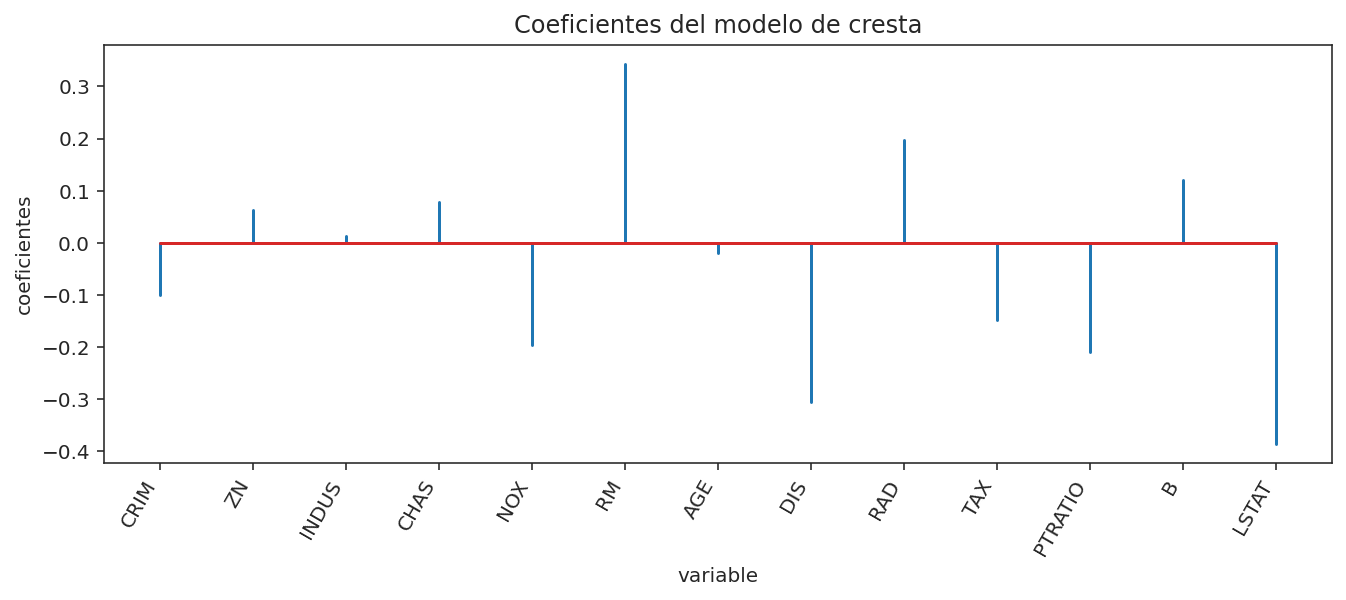

In [ ]:
# Dataframe con el valor de los coeficientes para cada variable
df_coeficientes_r2 = pd.DataFrame(
                        {'predictor': X2_train.columns,
                         'coef': ridge2.coef_.flatten()}
                  )

# Gráfico
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes_r2.predictor, df_coeficientes_r2.coef, markerfmt=' ')
plt.xticks(rotation=60, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo de cresta');

 Como se puede observar en el gráfico obtenido, las variables menos representativas o que menos peso tienen para este modelo son `INDUS` y `AGE` ya que son las que tienen un valor del coeficiente menor. Las variables que tienen coeficientes positivos ordenadas de menor a mayor valor son `INDUS`,`ZN`, `CHAS`, `B`, `RAD` y `RM`. Las que tienen valor negativo, ordenadas de menor a mayor peso son `AGE`, `CRIM`, `TAX`, `NOX`, `PTRATIO`, `DIS` y `LSTAT`. En este caso el resulatdo obtenido se parece al modelo de regresión lineal múltiple ajustado anteriormente. 



Evaluamos el modelo obtenido y lo comparamos con el de regresión lineal múltiple calculado al principio del modelo. En primer lugar obtenemos las predicciones de la muestra de validación para el modelo regularizado obtenido.

In [ ]:
# Uso del modelo para predecir el conjunto de test
predicciones = ridge2.predict(X2_test)
# presentamso las primeras 10 predicciones
predicciones[:10]

array([3.13861561, 3.88505747, 1.68693268, 2.71685933, 2.03923111,
       2.53449308, 1.93737096, 1.58645658, 2.46944726, 2.25983202])

Evaluamos la calidad del modelo obtenido

In [ ]:
# Predecir el conjunto de valores dependientes
y2_train_pred = ridge2.predict(X2_train)

print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y2_train, y2_train_pred),
        r2_score(y2_test, predicciones)))
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y2_train, y2_train_pred),
        mean_squared_error(y2_test, predicciones)))
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y2_train, y2_train_pred)),
        np.sqrt(mean_squared_error(y2_test, predicciones))))


R^2 entrenamiento: 0.750, validación: 0.667
MSE entrenamiento: 0.257, validación: 0.290
RMSE entrenamiento: 0.507, validación: 0.538


Las predicciones del modelo final se alejan en promedio 0.29 unidades del valor real.
El modelo explica el 75% de la variabilidad de la respuesta para la muestra de entrenamiento, y el 66.7% para la muestra de validación. Si lo comparamos con el de regresión lineal múltiple prácticamente no se observa ninguna mejora pues el valor de $R^2$ de entrenamiento es 0.75 para ambos modelos y el de validación pasa de ser 0.669 ajustando el modelo lineal a 0.667 ajustando la regresión de cresta. Además, el valor del error MSE pasa de ser 0.256 a 0.257 para el conjunto de entrenamiento y de 0.288 a 0.29 para el conjunto de validación.

En este caso el modelo de regularización no aporta mejoras significativas respecto del modelo habitual, ya que la penalización introducida sobre los coeficientes no resulta relevante. 

### US economic time series Dataset

Creamos y entrenamos el modelo con las divisiones de muestras del punto anterior. Para obtener el modelo óptimo, realizamos una búsqueda por validación cruzada del parámetro $\alpha$. 

In [ ]:
# Algoritmo Ridge para ajuste del modelo 
ridge3 = RidgeCV(
  alphas = np.linspace(0.001, 1, 200),
  fit_intercept = True,
  store_cv_values = True
)

# Ajuste para el conjunto de entrenamiento
ridge3.fit(X3_train, y3_train);

Una vez más, calculamos el valor del alpha óptimo encontrado.

In [ ]:
print(f"El mejor valor de alpha encontrado es: {round(ridge3.alpha_,5)}")

El mejor valor de alpha encontrado es: 0.01104


En este caso presentamos sólo la solución gráfica de los coeficientes obtenidos:

<ipython-input-41-e594b4c438aa>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


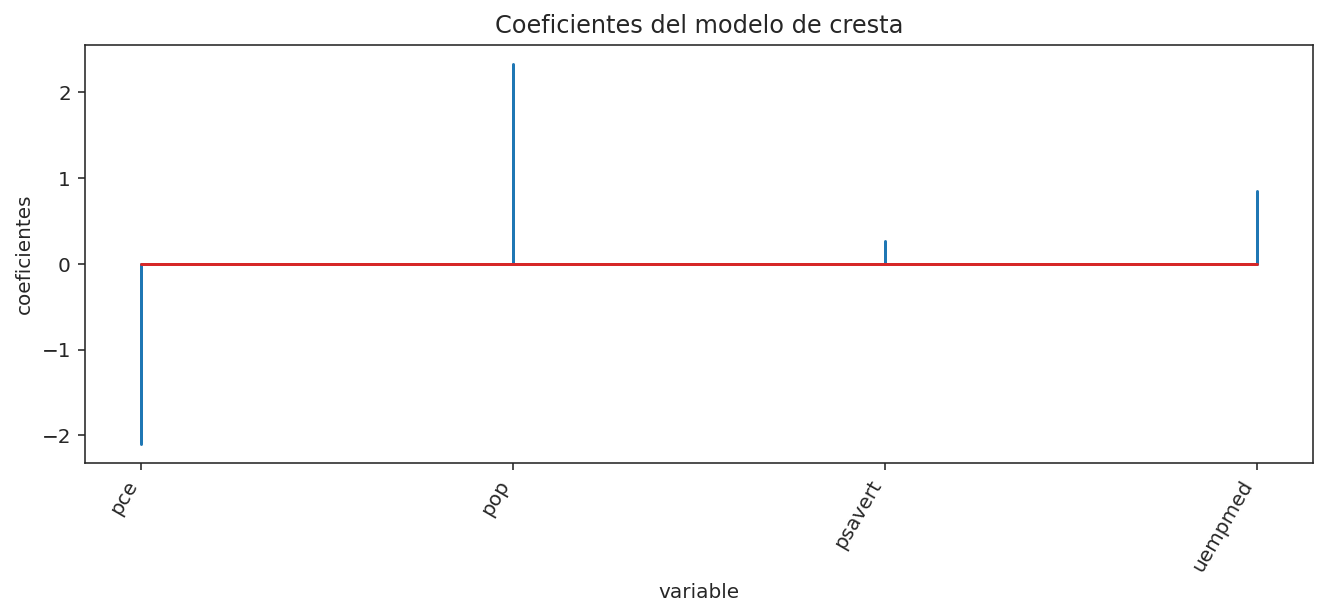

In [ ]:
# Dataframe con los valores de los coeficientes para cada variable
df_coeficientes_r3 = pd.DataFrame(
                        {'predictor': X3_train.columns,
                         'coef': ridge3.coef_.flatten()}
                  )

# Gráfico
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes_r3.predictor, df_coeficientes_r3.coef, markerfmt=' ')
plt.xticks(rotation=60, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo de cresta');

La variable menos representativa es `psavert` ya que es la que tiene el valor del coeficiente en valor absoluto menor y próximo a 0. Las variables que tienen coeficientes positivos ordenadas de menor a mayor valor son `psavert`, `uempmed` y `pop`. La única variable que tiene coeficiente negativo es `pce`. Comparamos las medidas de calidad del ajuste con el modelo original.

In [ ]:
# Predicciones 
predicciones = ridge3.predict(X3_test)
# Predecir el conjunto de valores dependientes
y3_train_pred = ridge3.predict(X3_train)

print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y3_train, y3_train_pred),
        r2_score(y3_test, predicciones)))
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y3_train, y3_train_pred),
        mean_squared_error(y3_test, predicciones)))
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y3_train, y3_train_pred)),
        np.sqrt(mean_squared_error(y3_test, predicciones))))

R^2 entrenamiento: 0.843, validación: 0.889
MSE entrenamiento: 0.147, validación: 0.139
RMSE entrenamiento: 0.383, validación: 0.373


En este modelo ajustado, las predicciones del modelo final se alejan en promedio 0.139 unidades del valor real.
El modelo explica el 84.3% de la variabilidad de la respuesta para la muestra de entrenamiento, y el 88.9% para la muestra de validación. Si lo comparamos con el de regresión lineal múltiple obtenemos los mismos valores de $R^2$, MSE y RMSE. Además, si observamos los coeficientes del modelo obtenido son prácticamente los mismos que los del modelo lineal. De nuevo, la penalización no tiene efeto debido al escaso número de predictoras.

### Meat spec Dataset

Creamos y entrenamos el modelo con las divisiones de muestras del punto anterior. Para obtener el modelo óptimo, realizamos una búsqueda por validación cruzada del parámetro  𝛼 .

In [ ]:
# Algoritmo Ridge para ajuste del modelo 
ridge4 = RidgeCV(
  alphas = np.linspace(0.01, 3, 200),
  fit_intercept = True,
  store_cv_values = True
)

# Ajuste para el conjunto de entrenamiento
ridge4.fit(X4_train, y4_train);

Calculamos el valor del alpha óptimo encontrado.

In [ ]:
print(f"El mejor valor de alpha encontrado es: {round(ridge4.alpha_,5)}")

El mejor valor de alpha encontrado es: 0.01


Representamos gráficamente los coeficientes del modelo:

<ipython-input-45-b4ed8c8b26ed>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


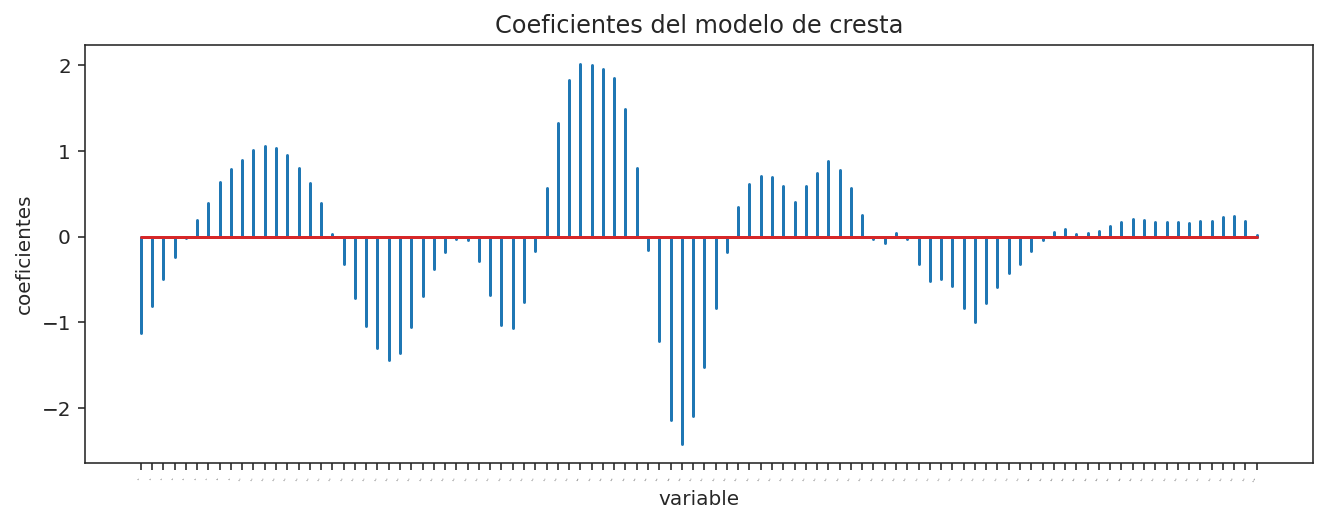

In [ ]:
# Dataframe con los valores de los coeficientes para cada variable
df_coeficientes4 = pd.DataFrame(
                        {'predictor': X4_train.columns,
                         'coef': ridge4.coef_.flatten()}
                  )

# Gráfico
fig, ax = plt.subplots(figsize=(11, 3.84));
ax.stem(df_coeficientes4.predictor, df_coeficientes4.coef, markerfmt=' ');
plt.xticks(rotation=60, ha='right', size=0);
ax.set_xlabel('variable');
ax.set_ylabel('coeficientes');
ax.set_title('Coeficientes del modelo de cresta');

En el gráfico podemos observar que los valores de los coeficientes del modelo se encuentran en el intervalo [-2.5,2]. En este caso si se aprecia con claridad el efecto de la penalización si comparamos con el gráfico de coeficientes del modelo original. Se aprecia un efecto de dependencia entre variables o longitudes de onda consecutivas indicando que las que están cerca deben afectar de forma similar a la respuesta. Podemos ver además que zona del espectro afecta al aumento de grasa (coeficientes positivos) y cual a la disminución (coeficientes negativos).

Analizamos la calidad del ajuste obtenido.

In [ ]:
# Predicciones 
predicciones_4 = ridge4.predict(X4_test)
# Predecir el conjunto de valores dependientes
y4_train_pred = ridge4.predict(X4_train)
print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y4_train, y4_train_pred),
        r2_score(y4_test, predicciones_4)))
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y4_train, y4_train_pred),
        mean_squared_error(y4_test, predicciones_4)))
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y4_train, y4_train_pred)),
        np.sqrt(mean_squared_error(y4_test, predicciones_4))))

R^2 entrenamiento: 0.956, validación: 0.951
MSE entrenamiento: 0.043, validación: 0.052
RMSE entrenamiento: 0.207, validación: 0.229


El modelo explica el 95.6% de la variabilidad de la respuesta para la muestra de entrenamiento, y el 95.1% para la muestra de validación. Si lo comparamos con el de regresión lineal múltiple se observan mejoras en el conjunto de validación pues el valor de $R^2$ de  pasa de ser 0.762 ajustando el modelo lineal a 0.951 ajustando la regresión de cresta. Además, el valor del error MSE pasa de ser 0.256 a 0.043. 
Por otro lado, en el conjunto de entrenamiento se pasa de un valor de $R^2$ de 0.996 ajustando el modelo lineal múltiple  a 0.951 ajustando la regresión de cresta. El valor del MSE pasa de 0.03 a 0.052. En este caso la penalización introducida es capaz de mejorar el modelo inicial de forma considerable.


## <font color="steelblue">Regresión de Lazo (Lasso regression)</font>

La **Regresión de Lazo** (Lasso) es un modelo lineal que estima coeficientes dispersos. Resulta útil en algunos contextos debido a su tendencia a preferir soluciones con menos coeficientes distintos de cero, reduciendo de hecho el número de variables predictoras de las que depende la solución dada. Matemáticamente, consiste en un modelo lineal con un término de regularización añadido. La función objetivo a minimizar es:

$$\underset{\mathbf{w}}{min} \frac{1}{2n}(||\mathbf{y} - \mathbf{X}\mathbf{w}||_2^2 + \alpha ||\mathbf{w}||_1)$$ 
 
La estimación Lasso resuelve así la minimización de la penalización por mínimos cuadrados añadiendo el término $\alpha ||\mathbf{w}||_1$, donde $\alpha$ es una constante y $||.||_1$ es la norma $L_1$ del vector de coeficientes. En este caso el parámetro $\alpha$ controla el grado de dispersión de los coeficienets estimados.

Este algortimo está concebido para ir elimiando progresivamente predictores en el modelo, de forma que podemos estudiar como evouciona el número de predictores en el modelo conforme varía el valor de la penalización ($\alpha$). A mayor penalización menor número de predictores en el modelo.

Para ajustar la regresión de Lazo, utilizamos la función [LassoCV()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html?highlight=lasso#sklearn.linear_model.LassoCV). Entre sus parámetros destacan:
* `alphas`: matriz de valores alfa para probar.
* `fit_intercept`: indica si se calcula la intersección para el modelo.
* `cv`: determina la estrategia de división de validación cruzada.


Importamos las funciones necesarias

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

### Housing Dataset

Calculamos, sobre la base de datos `Housing` la regresión de Lazo.

In [ ]:
# Algoritmo Lasso para ajuste del modelo 
lasso2 = LassoCV(
            alphas = np.linspace(0.01, 3, 200),
            cv = 10
         ); 
         
# Ajustar regresión Lasso al conjunto de entrenamiento 
lasso2.fit(X2_train, y2_train);

Estudiamos la evolución del número de predictores en función del valor de $\alpha$.

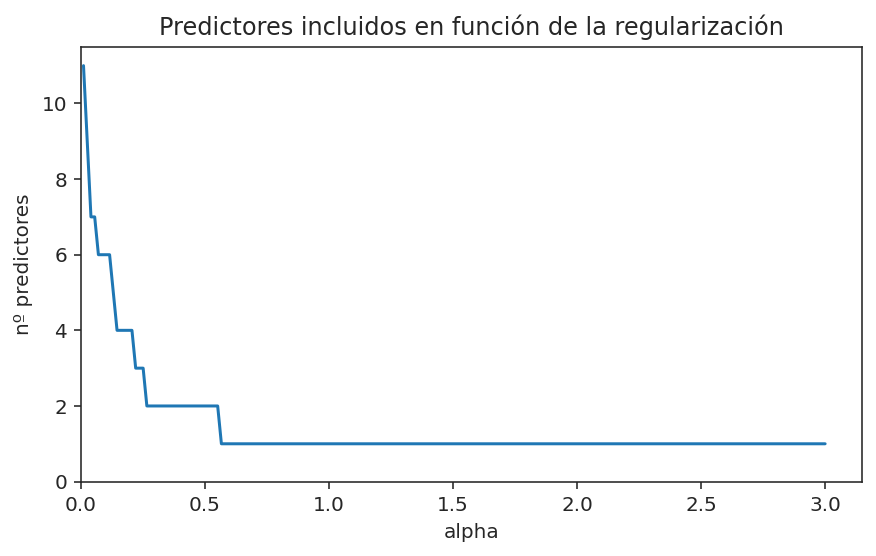

In [ ]:
alphas2 = lasso2.alphas_;
n_predictores = [];

# Bucle para obtener los n_predictores
for alpha in alphas2:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, max_iter= 10000)
    modelo_temp.fit(X2_train, y2_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero);

# Gráfico de evolución del número de predictores en función de alpha
fig, ax = plt.subplots(figsize=(7, 4));
ax.plot(alphas2, n_predictores);
ax.set_ylim([0,None]);
ax.set_xlim([0,None]);
ax.set_xlabel('alpha');
ax.set_ylabel('nº predictores');
ax.set_title('Predictores incluidos en función de la regularización');

Como era de esperar, a medida que aumenta el valor de alpha disminuye el número de predictores que se han incluído en el modelo. Obtenemos el valor óptimo de $\alpha$ para conocer el número de predictores relevantes en el modelo.

In [ ]:
print(f"Mejor valor de alpha encontrado: {round(lasso2.alpha_,5)}")

Mejor valor de alpha encontrado: 0.01


En este caso, al realizar la regresión de Lazo, el mejor alpha que encontramos tiene un valor que tiende a 0, eliminándose únicamente dos predictoras como se puede ver en el gráfico de coeficientes estimados que se muestra a continuación. 

<ipython-input-54-0184985b0cae>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


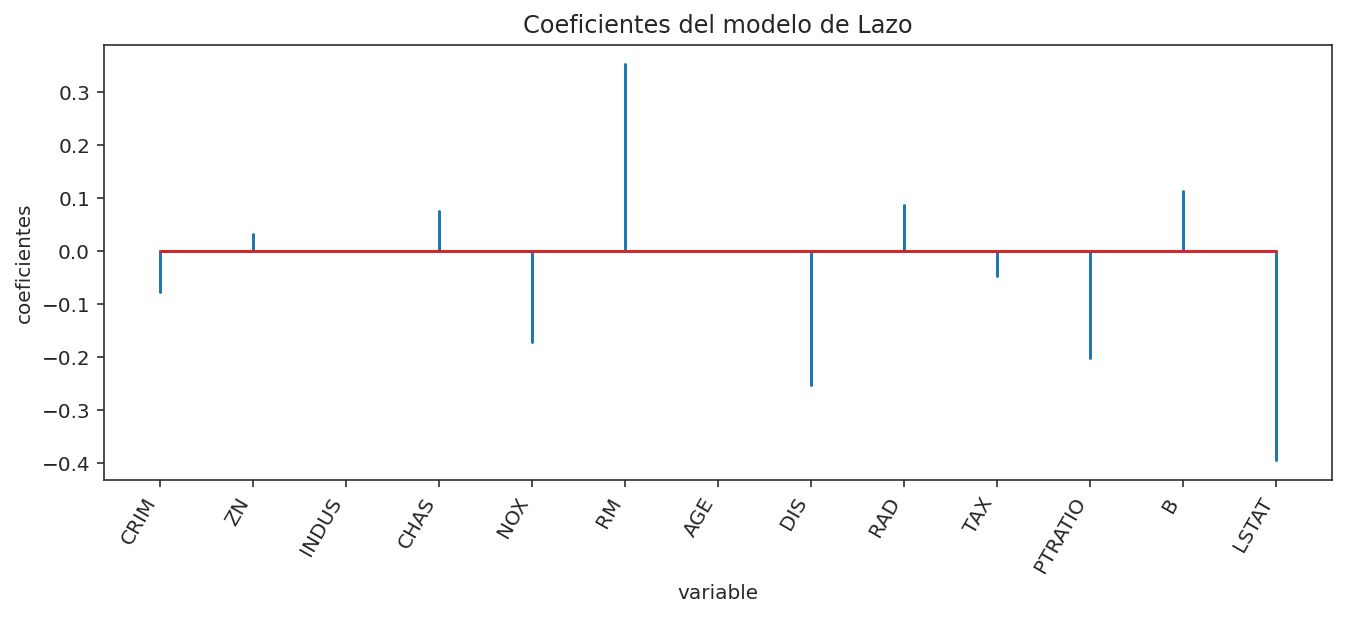

In [ ]:
# Dataframe con el valor de los coeficientes para cada variable
df_coeficientes_l2 = pd.DataFrame(
                        {'predictor': X2_train.columns,
                         'coef': lasso2.coef_.flatten()}
                  )

# Gráfico
fig, ax = plt.subplots(figsize=(11, 4))
ax.stem(df_coeficientes_l2.predictor, df_coeficientes_l2.coef, markerfmt=' ')
plt.xticks(rotation=60, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo de Lazo');

Las variables penalizadas con este modelo son  `INDUS` y `AGE` ya que sus coeficientes son 0. Las variables que tienen coeficientes positivos ordenadas de menor a mayor valor son `ZN`, `CHAS`, `RAD`, `B` y `RM`. Las que tienen valor negativo, ordenadas de menor a mayor peso son `TAX`,`CRIM`, `NOX`, `PTRATIO`, `DIS` y `LSTAT`. Las primeras afectan positivamente, aumentando el precio medio de las viviendas mientras que las segundas disminuyen el precio medio de la vivienda.

Estudiamos ahora la calidad el modelo obtenido con las medidas habituales.


In [ ]:
# Predicciones utilizando el modelo Lasso
y2_train_pred = lasso2.predict(X2_train)
y2_test_pred = lasso2.predict(X2_test)

print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y2_train, y2_train_pred),
        r2_score(y2_test, y2_test_pred)))
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y2_train, y2_train_pred),
        mean_squared_error(y2_test, y2_test_pred)))
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y2_train, y2_train_pred)),
        np.sqrt(mean_squared_error(y2_test, y2_test_pred))))

R^2 entrenamiento: 0.746, validación: 0.652
MSE entrenamiento: 0.262, validación: 0.302
RMSE entrenamiento: 0.511, validación: 0.550


Las predicciones del modelo final se alejan en promedio 0.652 unidades del valor real. Si comparamos las medidas obtenidas con las del modelo de regresión lineal múltiple tampoco se observan prácticamente mejoras ya que el valor de $R^2$ de entrenamiento es 0.751 para el lineal y 0.746 para el de Lazo y el de validación es 0.669 para ambos. El valor del error MSE pasa de ser 0.256 a 0.262 para el conjunto de entrenamiento y 0.288 a 0.302 para el conjunto de validación. Por tanto, tenemos un modelo con similar capacidad explicativa pero de donde hemos eliminado dos predictoras.

### US economic time series Dataset

Calculamos la regresión de Lazo ahora para el conjunto de datos `US economic time series` procediendo de forma similar al ejemplo anterior. En primer lugar preparamos el modelo para el ajuste:

In [ ]:
# Algoritmo Lasso para ajuste del modelo 
lasso3 = LassoCV(
            alphas = np.linspace(0.01, 3, 200),
            cv = 10
         ); 
# Ajustar regresión Lasso al conjunto de entrenamiento  
lasso3.fit(X3_train, y3_train);

Ajustamos y representamos el número de predictores en función del valor de $\alpha$.

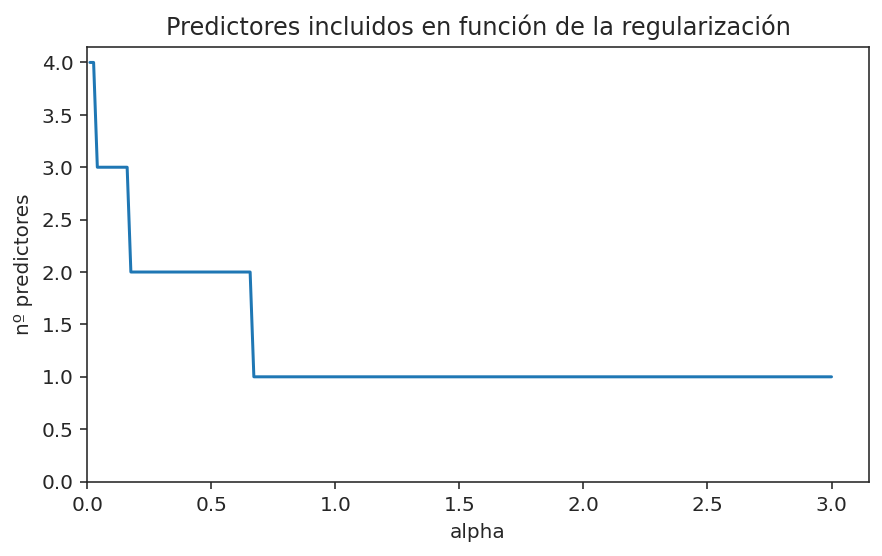

In [ ]:
alphas3 = lasso3.alphas_;
n_predictores = [];

# Bucle para obtener los valores de los coeficientes
for alpha in alphas3:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False);
    modelo_temp.fit(X3_train, y3_train);
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0);
    n_predictores.append(coef_no_cero);

# Gráfico
fig, ax = plt.subplots(figsize=(7, 4));
ax.plot(alphas3, n_predictores);
ax.set_ylim([0,None]);
ax.set_xlim([0,None]);
ax.set_xlabel('alpha');
ax.set_ylabel('nº predictores');
ax.set_title('Predictores incluidos en función de la regularización');

Obtenemos el valor óptimo de $\alpha$:

In [ ]:
print(f"Mejor valor de alpha encontrado: {round(lasso3.alpha_,6)}")

Mejor valor de alpha encontrado: 0.01


Igual que en el ejemplo de `Housing`, al realizar la regresión de Lazo, el mejor $\alpha$ que encontramos tiene un valor que tiende a 0. Por lo tanto, la corrección que estamos realizando es prácticamente inapreciable. De hecho podemos ver en la representación gráfica de los coeficientes que todos ellos son distintos de cero.

<ipython-input-55-d6000debb550>:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


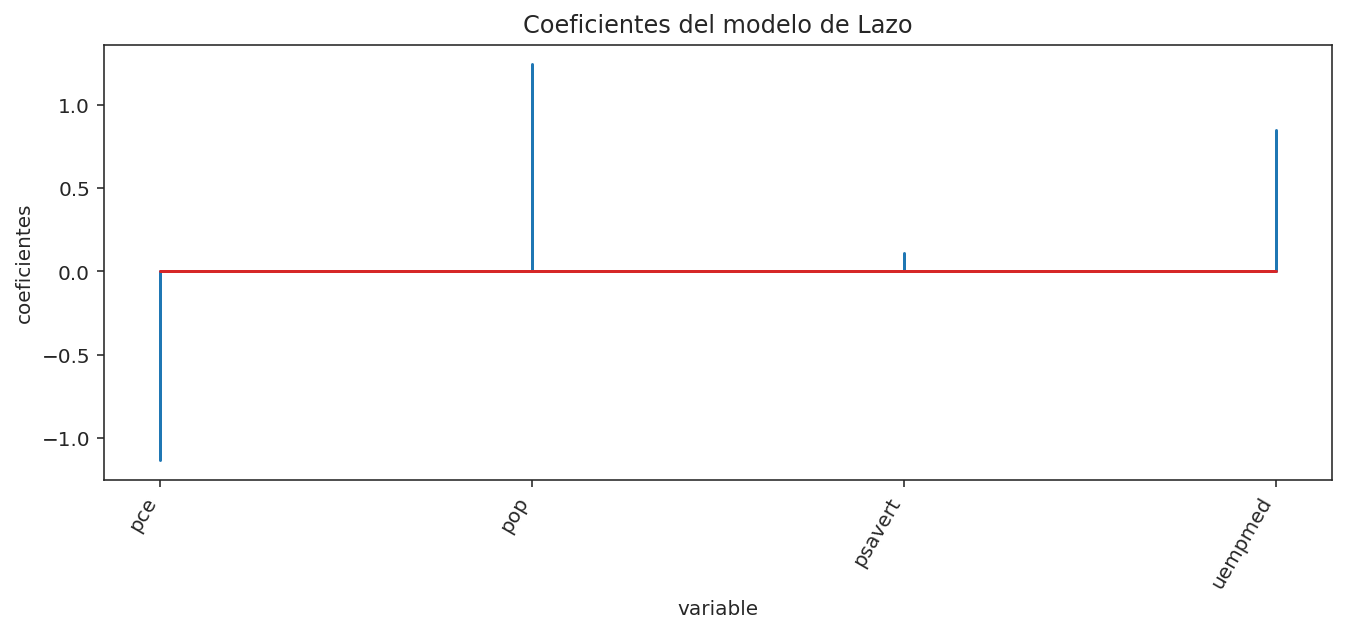

In [ ]:
# Dataframe con los valores de los coeficientes para cada predictor
df_coeficientes_l3 = pd.DataFrame(
                        {'predictor': X3_train.columns,
                         'coef': lasso3.coef_.flatten()}
                  )


# Gráfico
fig, ax = plt.subplots(figsize=(11, 4))
ax.stem(df_coeficientes_l3.predictor, df_coeficientes_l3.coef, markerfmt=' ')
plt.xticks(rotation=60, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo de Lazo');

Obtenemos los mismos coeficientes y, por lo tanto, el mismo modelo que al ajustar la regresión de cresta. Analizamos la calidad del ajuste aunque esperamos soluciones similares a las vistas hasta ahora para este conjunto de datos.

In [ ]:
# Predicciones sobre el conjunto de entrenamiento y de test
y3_train_pred = lasso3.predict(X3_train)
y3_test_pred = lasso3.predict(X3_test)

print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y3_train, y3_train_pred),
        r2_score(y3_test, y3_test_pred)))
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y3_train, y3_train_pred),
        mean_squared_error(y3_test, y3_test_pred)))
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y3_train, y3_train_pred)),
        np.sqrt(mean_squared_error(y3_test, y3_test_pred))))

R^2 entrenamiento: 0.819, validación: 0.876
MSE entrenamiento: 0.169, validación: 0.156
RMSE entrenamiento: 0.411, validación: 0.396


Como era de esperar, las medidas son del mismo orden que las del modelo de regresión lineal múltiple y la regresión de cresta.

### Meat spec Dataset

Analizamos ahora el modelo de Lazo para el conjunto de datos de longitudes de onda. Como ocurría en el caso de la regresión de cresta esperamos que el efecto de la penalización se haga notar debido al alto número de predictoras presentes en el modelo. Preparamos el modelo para el ajuste y reajustamos la tolerancia ya que el elevado número de predictoras hace que el algoritmo converja lentamente.

In [ ]:
# Algoritmo Lasso para ajuste del modelo 
lasso4 = LassoCV(
            alphas = np.linspace(0.01, 3, 200),
            cv = 10, tol = 0.015
         ); 
# Ajustar regresión Lasso al conjunto de entrenamiento  
lasso4.fit(X4_train, y4_train);

Representamos el número de predictores incluidos en función de $\alpha$. De nuevo modificamos el valor de tolerancia para asegurar convergencia.

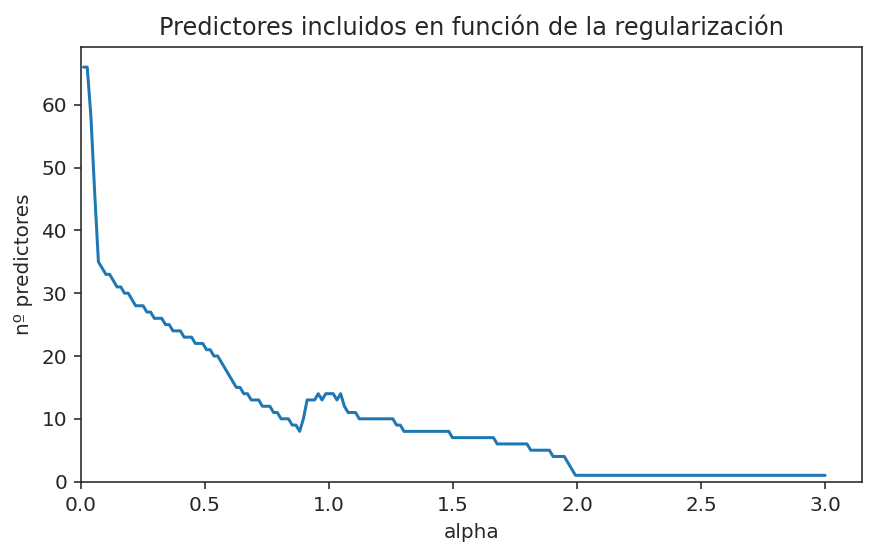

In [ ]:
alphas4 = lasso4.alphas_;
n_predictores = [];

# Bucle para obtener los valores de los coeficientes
for alpha in alphas4:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, tol = 0.1);
    modelo_temp.fit(X4_train, y4_train);
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0);
    n_predictores.append(coef_no_cero);

# Gráfico
fig, ax = plt.subplots(figsize=(7, 4));
ax.plot(alphas4, n_predictores);
ax.set_ylim([0,None]);
ax.set_xlim([0,None]);
ax.set_xlabel('alpha');
ax.set_ylabel('nº predictores');
ax.set_title('Predictores incluidos en función de la regularización');

In [ ]:
print(f"Mejor valor de alpha encontrado: {round(lasso4.alpha_,5)}")

Mejor valor de alpha encontrado: 0.01


Igual que en los ejemplos anteriores, al realizar la regresión de Lazo, el mejor $\alpha$ que encontramos tiene un valor que tiende a 0. Por lo tanto, la penalización introducida no es excesivamente grande pero si afecta al número de variables presentes en el modelo como se puede ver en el gráfico más adelante.

In [ ]:
# Obtenemos el intercept del modelo
np.round(lasso4.intercept_,3)

2.451

In [ ]:
# Coeficientes del modelo
df_coeficientes_l4 = pd.DataFrame(
                        {'predictor': X4_train.columns,
                         'coef': lasso4.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes_l4[df_coeficientes_l4.coef != 0].T

,5,6,7,8,9,10,11,12,13,14,...,36,37,38,39,40,49,50,51,52,53
predictor,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,...,V37,V38,V39,V40,V41,V50,V51,V52,V53,V54
coef,-0.283593,-0.581888,-0.519002,-0.465355,-0.399685,-0.344534,-0.288437,-0.228679,-0.166503,-0.106481,...,1.259574,1.383577,1.216854,0.858041,0.299653,-0.153098,-0.515993,-0.306156,-0.140533,-0.023177


De nuevo vemos la solución gráfica de los coeficientes:

<ipython-input-62-550687ed0c30>:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


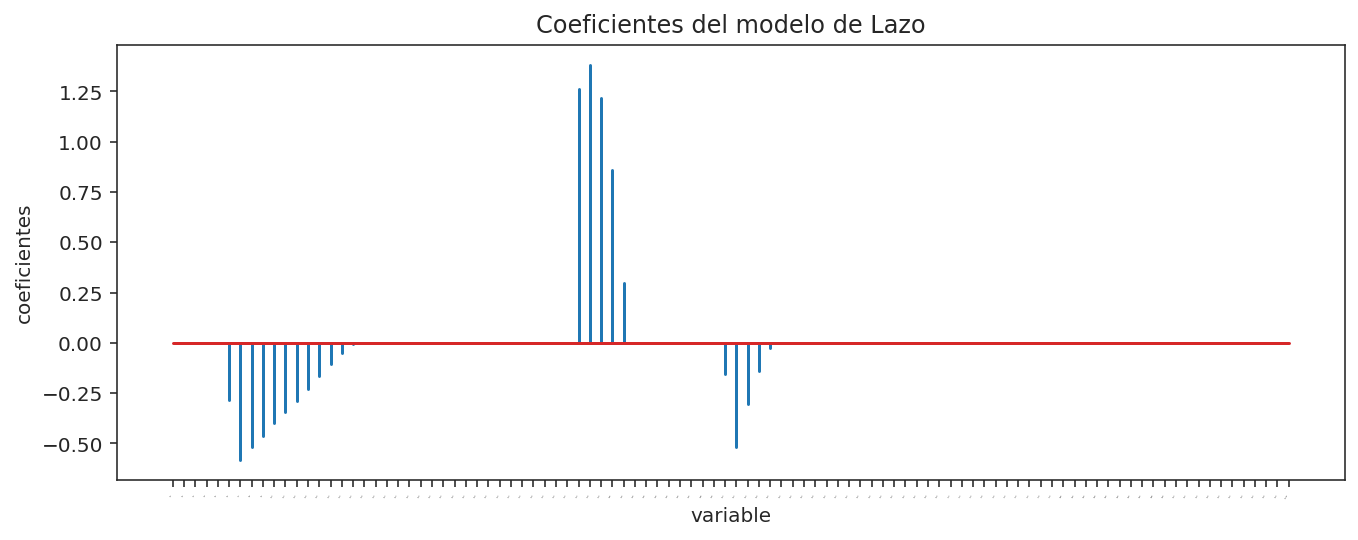

In [ ]:
# Gráfico
fig, ax = plt.subplots(figsize=(11, 4))
ax.stem(df_coeficientes_l4.predictor, df_coeficientes_l4.coef, markerfmt=' ')
plt.xticks(rotation=60, ha='right', size=0)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo de Lazo');

Podemos apreciar la gran cantidad de longitudes de onda (predictoras) con coeficientes iguales a 0. Esto se puede utilizar como un proceso de selección de predictoras para determinar el conjunto de longitudes de onda que debemos tener en cuenta para predecir el contenido de grasa. Veamos la calidad del ajuste obtenido comparado con el modelo de regresión lineal múltiple.

In [ ]:
# Predicciones sobre el conjunto de entrenamiento y de test
y4_train_pred = lasso4.predict(X4_train)
y4_test_pred = lasso4.predict(X4_test)

print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y4_train, y4_train_pred),
        r2_score(y4_test, y4_test_pred)))
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y4_train, y4_train_pred),
        mean_squared_error(y4_test, y4_test_pred)))
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y4_train, y4_train_pred)),
        np.sqrt(mean_squared_error(y4_test, y4_test_pred))))

R^2 entrenamiento: 0.882, validación: 0.932
MSE entrenamiento: 0.116, validación: 0.074
RMSE entrenamiento: 0.340, validación: 0.271


El modelo explica el 88.6% de la variabilidad de la respuesta para la muestra de entrenamiento, y el 93.3% para la muestra de validación. Si lo comparamos con el de regresión lineal múltiple se observan mejoras en el conjunto de validación pues el valor de $R^2$ pasa de ser 0.762 ajustando el modelo lineal a 0.933 ajustando la regresión de cresta. Además, el valor del error MSE pasa de ser 0.256 a 0.072. 
Por otro lado, en el conjunto de entrenamiento se pasa de un valor de $R^2$ de 0.996 ajustando el modelo lineal múltiple  a 0.886 ajustando la regresión de cresta. El valor del MSE pasa de 0.03 a 0.112.

De esta forma conseguimos un modelo con mejor capacidad predictora pero donde el número de predictoras es muy inferior al del banco de datos original.


## <font color="steelblue">Regresión de Red Elástica (Elastic Net)</font>

La **Regresión de Red Elástica** (Elastic Net) es una modificación de la regresión lineal que combina la penalización l1 y l2, es decir, la regresión de Lazo y la de Cresta. En el procedimiento, la estrategia habitual es primero encontrar el coeficiente de regresión de la cresta y después realizar un algoritmo de Lazo sobre el coeficiente de regresión para reducirlo. La combinación de ambas penalizaciones suele dar lugar a buenos resultados.

La función objetivo a minimizar es una especie de mixtura entre ambas penalizaciones y viene dada por:

$$\underset{\mathbf{w}}{min} \frac{1}{2n}(||\mathbf{y} - \mathbf{X}\mathbf{w}||_2^2 + \alpha*l1ratio*||\mathbf{w}||_1 + 0.5*\alpha*(1-l1ratio) ||\mathbf{w}||_2^2$$

El grado en que influye cada una de las penalizaciones está controlado por el hiperparámetro $l1ratio$, cuyo valor está comprendido entre los valores 0 y 1, de forma que si toma el valor cero estamos con la penalización l2 (regresión de lazo), mientras que si toma el valor 1 estamos con la penalización l1 (regresión de cresta).

En forma reducida podemos expresar el término de penalización como:

$$a||\mathbf{w}||_1 + 0.5*b||\mathbf{w}||_2^2,$$

de forma que

$$\alpha = a+b \quad \text{y} \quad l1ratio=\frac{a}{a+b}.$$

Para ajustar la regresión de red elástica, utilizamos la función [ElasticNetCV()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html?highlight=elasticnet#sklearn.linear_model.ElasticNetCV). Entre sus parámetros destacan:
* `alpha`: constante que multiplica los términos de penalización. 
* `l1_ratio` ($l1ratio$): valor entre 0 y 1. 
* `fit_intercept`: indica si se calcula la intersección para el modelo.
* `cv`: determina la estrategia de división de validación cruzada.


Importamos las funciones de interés

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

### Housing Dataset

Procedemos con la estimación del modelo de red elástica para un grid de valores de `l1_ratio` y $\alpha$.

In [ ]:
# Algoritmo ElasticNet para ajuste del modelo 
elasticnet2 = ElasticNetCV(
            l1_ratio = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
            alphas = np.logspace(-10, 3, 100),
            cv = 10
         );

# Ajustar regresión de red elástica al conjunto de entrenamiento 
elasticnet2.fit(X2_train, y2_train);

Observamos la evolución del error en función del valor de $\alpha$ y de $l1ratio$.

In [ ]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = elasticnet2.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) que conviertimos 
# en un dataframe
df_resultados_cv2 = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [elasticnet2.l1_ratio, elasticnet2.alphas_],
                                    names     = ['l1_ratio', 'elasticnet2.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv2['rmse_cv'] = np.sqrt(df_resultados_cv2['mse_cv'])
df_resultados_cv2 = df_resultados_cv2.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv2

,l1_ratio,elasticnet2.alphas_,mse_cv,rmse_cv
36,0.01,0.018738,0.285051,0.533902
37,0.01,0.013849,0.285091,0.533939
35,0.01,0.025354,0.285095,0.533943
136,0.05,0.018738,0.285136,0.533982
137,0.05,0.013849,0.285137,0.533983
...,...,...,...,...
411,0.30,35.938137,1.032400,1.016071
412,0.30,26.560878,1.032400,1.016071
413,0.30,19.630407,1.032400,1.016071
415,0.30,10.722672,1.032400,1.016071


En todo el grid observado determinamos los valores óptimos de los dos parámetros de interés.

In [ ]:
print(f"El mejor valor de alpha encontrado es {round(elasticnet2.alpha_,3)}")
print(f"El mejor valor de l1_ratio encontrado es {round(elasticnet2.l1_ratio_,3)}")

El mejor valor de alpha encontrado es 0.019
El mejor valor de l1_ratio encontrado es 0.01


Representamos gráficamente la evolución del error de validación cruzada con respecto a los dos parámetros de interés.

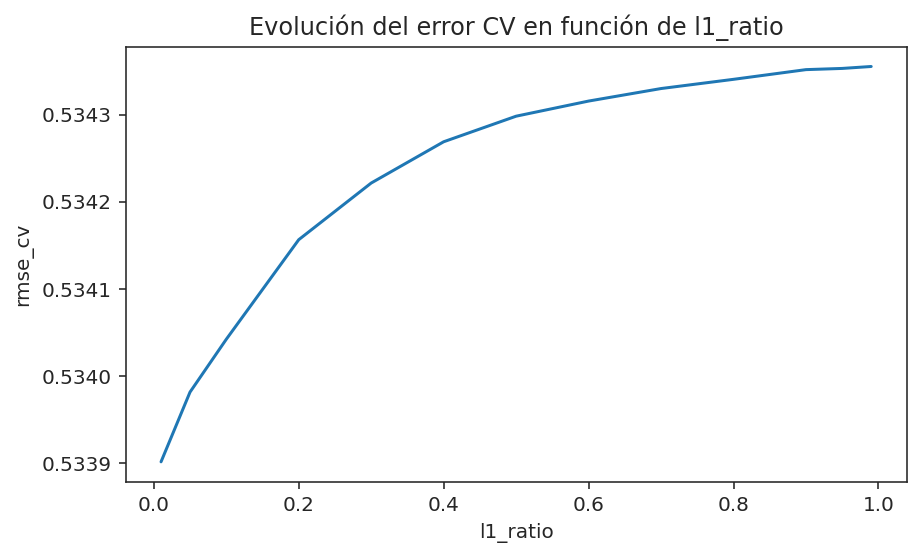

In [ ]:
# Gráfico l1ratio
fig, ax = plt.subplots(figsize=(7, 4))
df_resultados_cv2.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

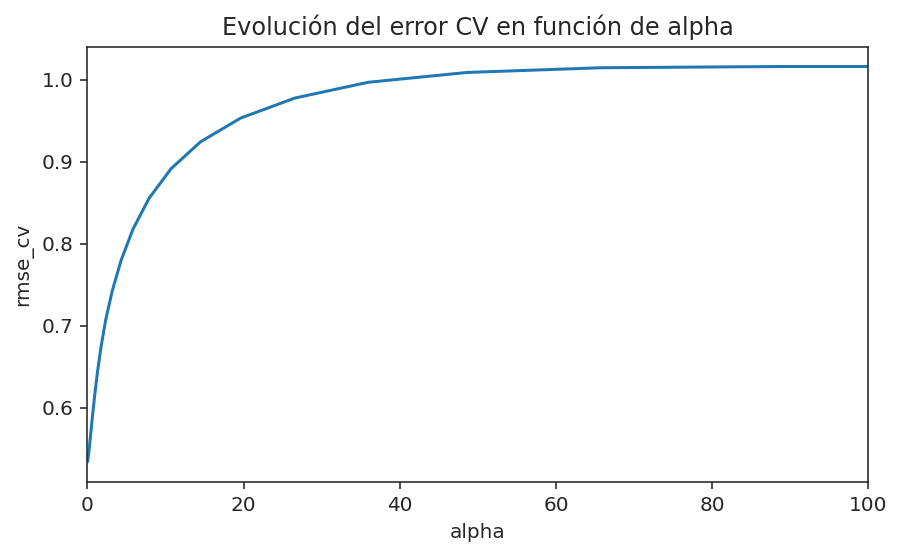

In [ ]:
# Gráfico alphas
fig, ax = plt.subplots(figsize=(7, 4))
df_resultados_cv2.groupby('elasticnet2.alphas_')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de alpha')
ax.set_xlim([0,100])
ax.set_xlabel('alpha')
ax.set_ylabel('rmse_cv');

Observamos que el menor `mse_cv` se da cuando `l1_ratio` es prácticamente 0. Una vez obtenidos los valores óptimos de alpha y l1_ratio calculamos los coeficientes del modelo. De nuevo presentamos la solución gráfica:

<ipython-input-70-55f77d99246c>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


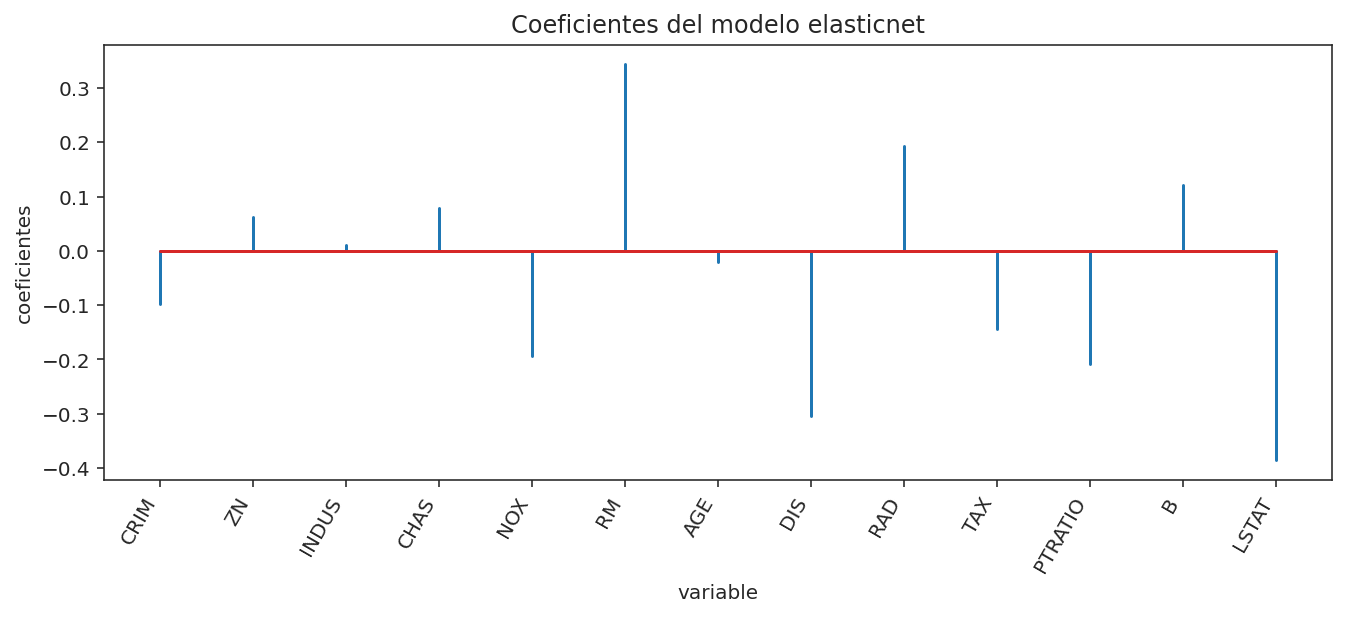

In [ ]:
# Coeficientes del modelo
df_coeficientes_en2 = pd.DataFrame(
                        {'predictor': X2_train.columns,
                         'coef': elasticnet2.coef_.flatten()}
                  )

# Gráfico
fig, ax = plt.subplots(figsize=(11, 4))
ax.stem(df_coeficientes_en2.predictor, df_coeficientes_en2.coef, markerfmt=' ')
plt.xticks(rotation=60, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo elasticnet');

Los coeficientes obtenidos son muy similares a los del modelo original, con lo que la penalización no tiene un efecto relevante sobre la predicción. Estudiamos la capacidad predictora del nuevo modelo.

In [ ]:
# Predicciones
y2_train_pred = elasticnet2.predict(X2_train)
y2_test_pred = elasticnet2.predict(X2_test)

print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y2_train, y2_train_pred),
        r2_score(y2_test, y2_test_pred)))
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y2_train, y2_train_pred),
        mean_squared_error(y2_test, y2_test_pred)))
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y2_train, y2_train_pred)),
        np.sqrt(mean_squared_error(y2_test, y2_test_pred))))


R^2 entrenamiento: 0.750, validación: 0.666
MSE entrenamiento: 0.257, validación: 0.290
RMSE entrenamiento: 0.507, validación: 0.538


Los valores obtenidos son del mismo orden que los vistos hasta ahora con el resto de modelos. No se introducen mejoras significatvas en la predicción de la respuesta.

### US economic time series Dataset

Analizamos ahora el modelo de red elástica sobre el conjunto de datos sobre losngitudes de onda para predecir el contenido de grasa.

In [ ]:
# Ajuste del modelo
elasticnet3 = ElasticNetCV(
            l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
            alphas = np.linspace(0.01, 3, 200),
            cv = 10
         );
# Entrenamiento del modelo
elasticnet3.fit(X3_train, y3_train);

Una vez más, observamos la evolución del error en función del valor de `alpha` y de `l1_ratio`.

In [ ]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = elasticnet3.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) que conviertimos 
# en un dataframe
df_resultados_cv3 = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [elasticnet3.l1_ratio, elasticnet3.alphas_],
                                    names     = ['l1_ratio', 'elasticnet3.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv3['rmse_cv'] = np.sqrt(df_resultados_cv3['mse_cv'])
df_resultados_cv3 = df_resultados_cv3.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv3

,l1_ratio,elasticnet3.alphas_,mse_cv,rmse_cv
1799,0.9,0.010000,0.175184,0.418550
1599,0.8,0.010000,0.175376,0.418779
1399,0.7,0.010000,0.175542,0.418978
1199,0.6,0.010000,0.175689,0.419152
999,0.5,0.010000,0.175819,0.419308
...,...,...,...,...
1305,0.7,1.422362,0.937002,0.967988
1306,0.7,1.407337,0.937002,0.967988
1307,0.7,1.392312,0.937002,0.967988
1299,0.7,1.512513,0.937002,0.967988


Como en el ejemplo anterior, se puede observar para cada uno de los registros un valor de `l1ratio` y `alpha`. Calculamos analíticamente el mejor valor de `l1ratio` y de `alpha`. 

In [ ]:
print(f"Mejor valor de alpha encontrado es {round(elasticnet3.alpha_,6)}")
print(f"Mejor valor de l1_ratio encontrado es {round(elasticnet3.l1_ratio_,6)}")

Mejor valor de alpha encontrado es 0.01
Mejor valor de l1_ratio encontrado es 0.9


Observamos que el mejor valor de `alpha` tiende a 0 y el valor de `l1_ratio` es próximo a 1, por lo tanto nos encontramos ante una solución similar o próxima a la regresión de Cresta. Obtenemos la solución gráfica de los coeficientes del modelo.

<ipython-input-75-c0692547486e>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


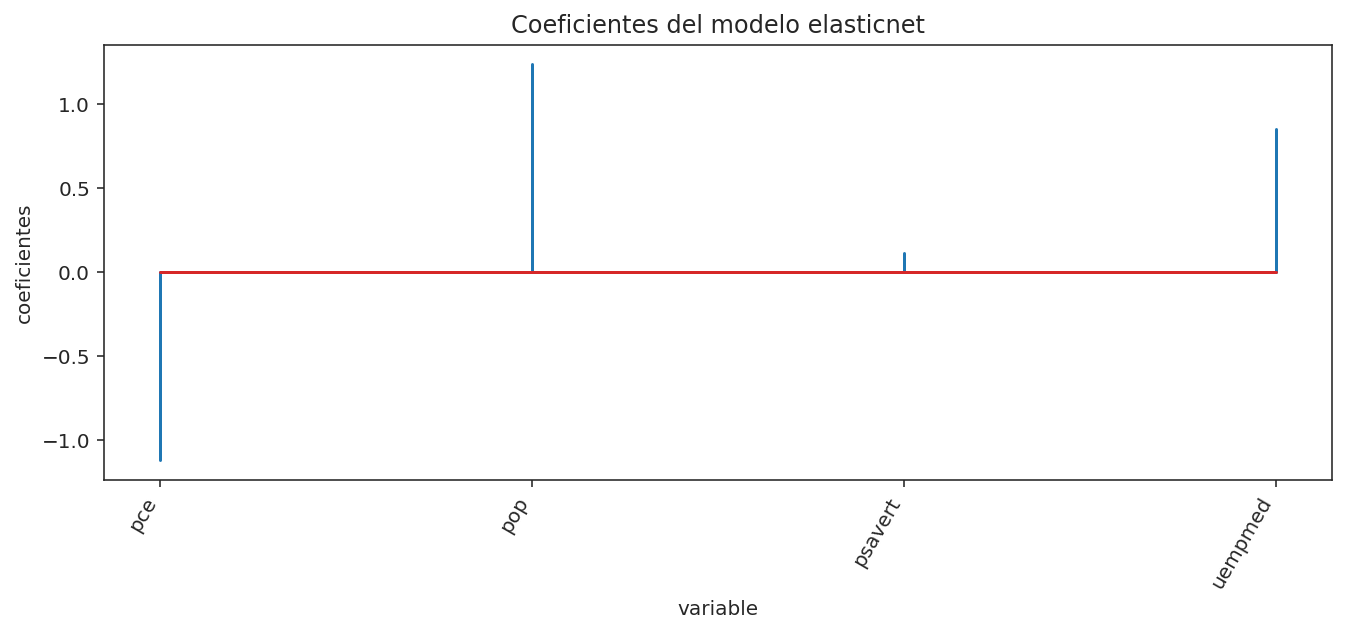

In [ ]:
# Coeficientes del modelo
df_coeficientes_en3 = pd.DataFrame(
                        {'predictor': X3_train.columns,
                         'coef': elasticnet3.coef_.flatten()}
                  )

# Gráfico
fig, ax = plt.subplots(figsize=(11, 4))
ax.stem(df_coeficientes_en3.predictor, df_coeficientes_en3.coef, markerfmt=' ')
plt.xticks(rotation=60, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo elasticnet');

Este modelo también introduce las cuatro variables predictoras originales. Analizamos la predicción del modelo resultante.

In [ ]:
# Predicciones
y3_train_pred = elasticnet3.predict(X3_train)
y3_test_pred = elasticnet3.predict(X3_test)
print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y3_train, y3_train_pred),
        r2_score(y3_test, y3_test_pred)))
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y3_train, y3_train_pred),
        mean_squared_error(y3_test, y3_test_pred)))
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y3_train, y3_train_pred)),
        np.sqrt(mean_squared_error(y3_test, y3_test_pred))))


R^2 entrenamiento: 0.818, validación: 0.875
MSE entrenamiento: 0.170, validación: 0.157
RMSE entrenamiento: 0.412, validación: 0.397


Como era de esperar los resultados obtenidos son similares a los de modelos anteriores. En este caso las diferentes penalizaciones no parecen aportar grandes cambios sobre la solución original para este banco de datos.

### Meat spec Dataset

Por último ajustamos la regresión de Elastic Net a la base de datos `meatspec`. Modificamos de nuevo la tolerancia para asegurar la convergencia del modelo.

In [ ]:
# Ajuste del modelo
elasticnet4 = ElasticNetCV(
            l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
            alphas = np.linspace(0.01, 3, 200),
            cv = 10, tol = 0.07
         );
# Entrenamiento del modelo
elasticnet4.fit(X4_train, y4_train);

Obtenemos analíticamente el mejor valor de $\alpha$ y de $l1ratio$ para el grid de datos analizado.

In [ ]:
print(f"Mejor valor de alpha encontrado es {round(elasticnet4.alpha_,6)}")
print(f"Mejor valor de l1_ratio encontrado es {round(elasticnet4.l1_ratio_,6)}")

Mejor valor de alpha encontrado es 0.01
Mejor valor de l1_ratio encontrado es 0.4


Vemos la solución gráfica del conjunto de coeficientes estimados con este modelo.

<ipython-input-79-173ce4eea084>:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


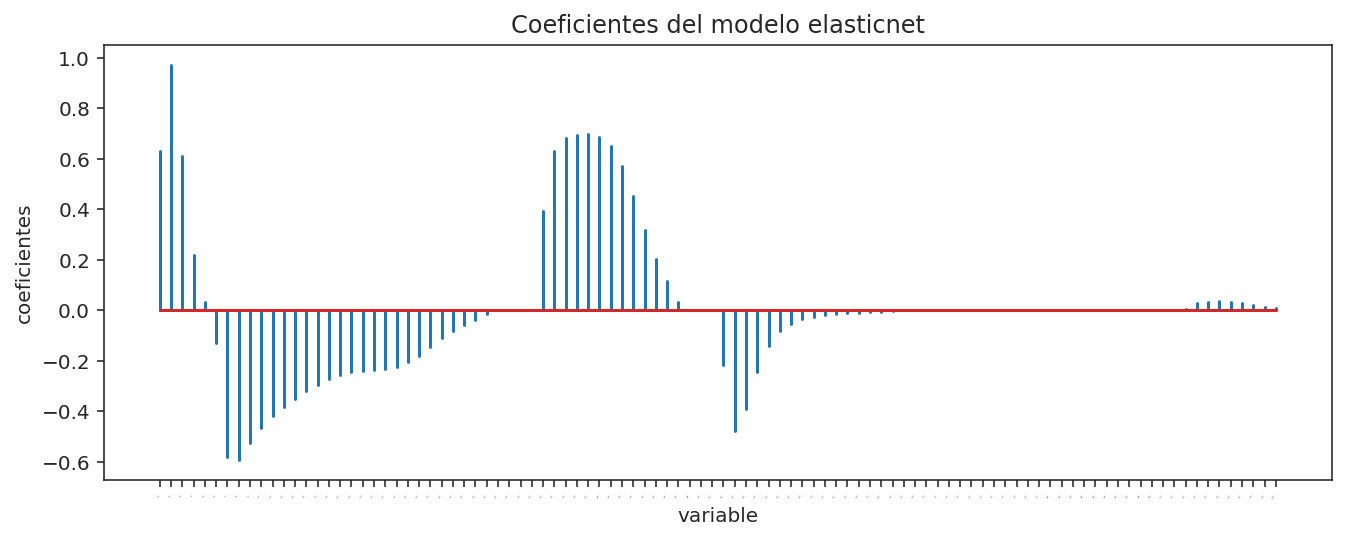

In [ ]:
# Coeficientes del modelo
df_coeficientes_en4 = pd.DataFrame(
                        {'predictor': X4_train.columns,
                         'coef': elasticnet4.coef_.flatten()}
                  )
# Gráfico
fig, ax = plt.subplots(figsize=(11, 4))
ax.stem(df_coeficientes_en4.predictor, df_coeficientes_en4.coef, markerfmt=' ')
plt.xticks(rotation=60, ha='right', size=0)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo elasticnet');

Como era de esperar la solución obtenida es una mezcla entre la solución de regresión de Cresta y Lazo. Las longitudes de onda tienen un comportamiento suave, relacionando más las que están más cerca, y tiende a tomar valores próximos a cero en aquellas longitudes de onda que eran identificadas en la regresión de Lazo.

Analizamos la capacidad predictiva de la solución obtenida.

In [ ]:
# Predicciones
y4_train_pred = elasticnet4.predict(X4_train)
y4_test_pred = elasticnet4.predict(X4_test)
print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y4_train, y4_train_pred),
        r2_score(y4_test, y4_test_pred)))
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y4_train, y4_train_pred),
        mean_squared_error(y4_test, y4_test_pred)))
print('RMSE entrenamiento: %.3f, validación: %.3f' % (
        np.sqrt(mean_squared_error(y4_train, y4_train_pred)),
        np.sqrt(mean_squared_error(y4_test, y4_test_pred))))

R^2 entrenamiento: 0.919, validación: 0.948
MSE entrenamiento: 0.079, validación: 0.056
RMSE entrenamiento: 0.281, validación: 0.237


De nuevo la solución es una combinación de las soluciones anteriores mejorando la solución del modelo inicial. Por tanto, las soluciones de Lazo y Red Elástica parecen proporcionar una mejor solución para este banco de datos.

## <font color="steelblue">Resumen comparativo de modelos</font>

A continuación presentamos un resumen comparativo de todos los modelos obtenidos en este cuaderno. En concreto nos centramos en las medidas de predicción obtenidas para cada uno de ellos. Se recomienda revisar las soluciones gráficas de los coeficientes para apreciar los pesos de las predictoras en cada uno de los modelos propuestos. Se ha marcado en negrita la mejor opción para la muestra de validación en cada uno de los conjuntos de datos.

### Housing Dataset

Indicadores del modelo para la muestra de entrenamiento y validación:

| Modelo                  |   Muestra      |$R^2$   | MSE  | RMSE  |
|-------------------------|----------------|--------|------|-------|
|Regresión lineal multiple|Entrenamiento   | 0.751  | 0.256| 0.506 |
|                         |Validación      | **0.669**  | **0.288**| **0.537** |
|Regresión de cresta      |Entrenamiento   | 0.750  | 0.257| 0.507 |
|                         |Validación      | 0.667  | 0.290| 0.538 |
|Regresión lazo           |Entrenamiento   | 0.746  | 0.262| 0.511 |
|                         |Validación      | 0.652  | 0.302| 0.550 |
|Regresión de red elástica|Entrenamiento   | 0.750  | 0.257| 0.507 |
|                         |Validación      | 0.666  | 0.290| 0.538 |

### US economic time series Dataset

Indicadores del modelo para la muestra de entrenamiento y validación:

| Modelo                  |   Muestra      |$R^2$   | MSE  | RMSE  |
|-------------------------|----------------|--------|------|-------|
|Regresión lineal multiple|Entrenamiento   | 0.843  | 0.147| 0.383 |
|                         |Validación      | **0.889**  | **0.139**| **0.373** |
|Regresión de cresta      |Entrenamiento   | 0.843  | 0.147| 0.383 |
|                         |Validación      | **0.889**  | **0.139**| **0.373** |
|Regresión lazo           |Entrenamiento   | 0.819  | 0.169| 0.411 |
|                         |Validación      | 0.876  | 0.156| 0.396 |
|Regresión de red elástica|Entrenamiento   | 0.818  | 0.170| 0.412 |
|                         |Validación      | 0.875  | 0.157| 0.397 |

### Meat spec Dataset

Indicadores del modelo para la muestra de entrenamiento y validación:

| Modelo                  |   Muestra      |$R^2$   | MSE  | RMSE  |
|-------------------------|----------------|--------|------|-------|
|Regresión lineal multiple|Entrenamiento   | 0.996  | 0.003| 0.059 |
|                         |Validación      | 0.762  | 0.256| 0.506 |
|Regresión de cresta      |Entrenamiento   | 0.956  | 0.043| 0.207 |
|                         |Validación      | **0.951**  | **0.052**| **0.229** |
|Regresión lazo           |Entrenamiento   | 0.882  | 0.116| 0.340 |
|                         |Validación      | 0.932  | 0.074| 0.271 |
|Regresión de red elástica|Entrenamiento   | 0.916  | 0.083| 0.287 |
|                         |Validación      | 0.943  | 0.061| 0.248 |

# <font color="steelblue">Ampliar conocimientos</font>

Se puede profundizar más sobre otros tipos de modelos lineales haciendo uso de la libreria `statmodels`. Esta librería contiene un apartado específico para los modelos lineales de regresión (https://www.statsmodels.org/stable/regression.html), y un apartado para estimar los modelos regularizados via Red Elástica (https://www.statsmodels.org/stable/_modules/statsmodels/base/elastic_net.html#RegularizedResults). 

Sin embargo, esta librería requiere de unos conocimientos estadísticos más avanzados tanto para el planteamiento de los modelos como su análisis. Se recomienda su uso en aquellos estudiantes con conocimientos de modelización estadística avanzada. 



# <font color="steelblue">Referencias y enlaces de interés</font>


Manuales

* Aurélien Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media.

* Peters Morgan (2018). Data Analysis From Scratch With Python: Beginner Guide using Python, Pandas, NumPy, Scikit-Learn, IPython, TensorFlow and Matplotlib. AI Sciences LLC.

* Sebastian Raschka, Vahid Mirjalili (2017). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow. Packt Publishing.

* Julian Avila (2017). Scikit-Learn Cookbook: Over 80 Recipes for Machine Learning in Python With Scikit-Learn. Packt Publishing

Enlaces

* Scikit-Learn. Linear Models: https://scikit-learn.org/stable/modules/linear_model.html#

* Python Data Science Handbook: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb#scrollTo=rEF3UsBsJnuZ

* Nyandwi, J.D. Mahine Learning Complete. Linear Models for Regression: https://github.com/Nyandwi/machine_learning_complete/blob/main/6_classical_machine_learning_with_scikit-learn/1_linear_models_for_regression.ipynb

* Raschka, S. (2015). Python Machine Learning. Chapter 10: https://github.com/PacktPublishing/Python-Machine-Learning/blob/master/3547_10_Code.ipynb

* Amat, J. (2020). https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html

* Amat, J. (2020). https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html